It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/RNN/Introduction_to_RNN_Time_Series.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/Introduction_to_RNN_Time_Series.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

#### Import keras

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

# Simple Architectures

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In time series forecasting we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [2]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


这是在用 Keras 的 LSTM 层做一次“最小例子”的前向计算，演示不同参数下输出张量的形状。

逐行说明：

inputs = tf.random.normal([32, 10, 4])

造一个假数据张量当输入。

形状是 [batch, timesteps, features] = [32, 10, 4]：

32：一次喂 32 条样本（批大小）。

10：每条样本是长度为 10 的序列（10 个时间步）。

4：每个时间步有 4 维特征。

lstm = tf.keras.layers.LSTM(units=2)

建一个 LSTM 层，units=2 表示隐藏单元数是 2。

对 LSTM 来说，这意味着隐藏状态
ℎ
𝑡
h
t
	​

 和细胞状态
𝑐
𝑡
c
t
	​

 的维度都是 2。

这里没有显式设置 return_sequences 和 return_state，因此使用默认值：

return_sequences=False（不返回所有时间步，只返回最后一个时间步的输出）

return_state=False（不额外返回
ℎ
𝑡
,
𝑐
𝑡
h
t
	​

,c
t
	​

）

output = lstm(inputs)

把形状为 (32, 10, 4) 的序列输入 LSTM。

因为 return_sequences=False，LSTM 只输出最后一个时间步的输出，所以每条序列得到一个长度为 2 的向量。

打印：output.shape → (32, 2)

对每条样本一行（batch 维 32），每行是 2 维（units=2）。

直观理解：10 个时间步“读完”为一个 2 维摘要向量。

### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [5]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


这是在搭一个三层堆叠 LSTM的小模型，并用一批随机数据做了一次前向计算，主要目的是演示堆叠时 return_sequences 如何影响张量形状。

逐行/逐层解释（形状跟踪）：

timesteps = 10, features = 8
序列长度 10、每个时间步 8 维特征。

inputs = tf.keras.Input(shape=(timesteps, features), name='input')
定义模型输入占位：形状 (None, 10, 8)，其中 None 是批大小。

lstm_1 = layers.LSTM(64, return_sequences=True)(inputs)
第1层 LSTM（单元数 64）。
return_sequences=True ⇒ 每个时间步都输出一个 64 维向量，形状：(batch, 10, 64)。

lstm_2 = layers.LSTM(64, return_sequences=True)(lstm_1)
第2层也返回整个序列，所以输出仍是 (batch, 10, 64)。
👉 堆叠 LSTM 时，中间层必须 return_sequences=True，否则下一层拿不到按时间展开的序列。

lstm_3 = layers.LSTM(64, return_sequences=False)(lstm_2)
最后一层只要最后一个时间步的输出（“one-to-many / many-to-one”场景），所以形状变成 (batch, 64)。

model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
组装成 Keras 函数式模型。

inputs = tf.random.normal([32, timesteps, features])
生成一批随机输入数据，形状 (32, 10, 8)。这里把变量名 inputs 重新用作“数据”，会遮蔽上面的“Input 占位符”，不影响这次演示但容易混淆（建议改名 x_batch）。

print(model(inputs).shape) → (32, 64)
对 32 条样本做前向；每条样本最终得到一个 64 维向量（来自最后一层的最后时刻）。

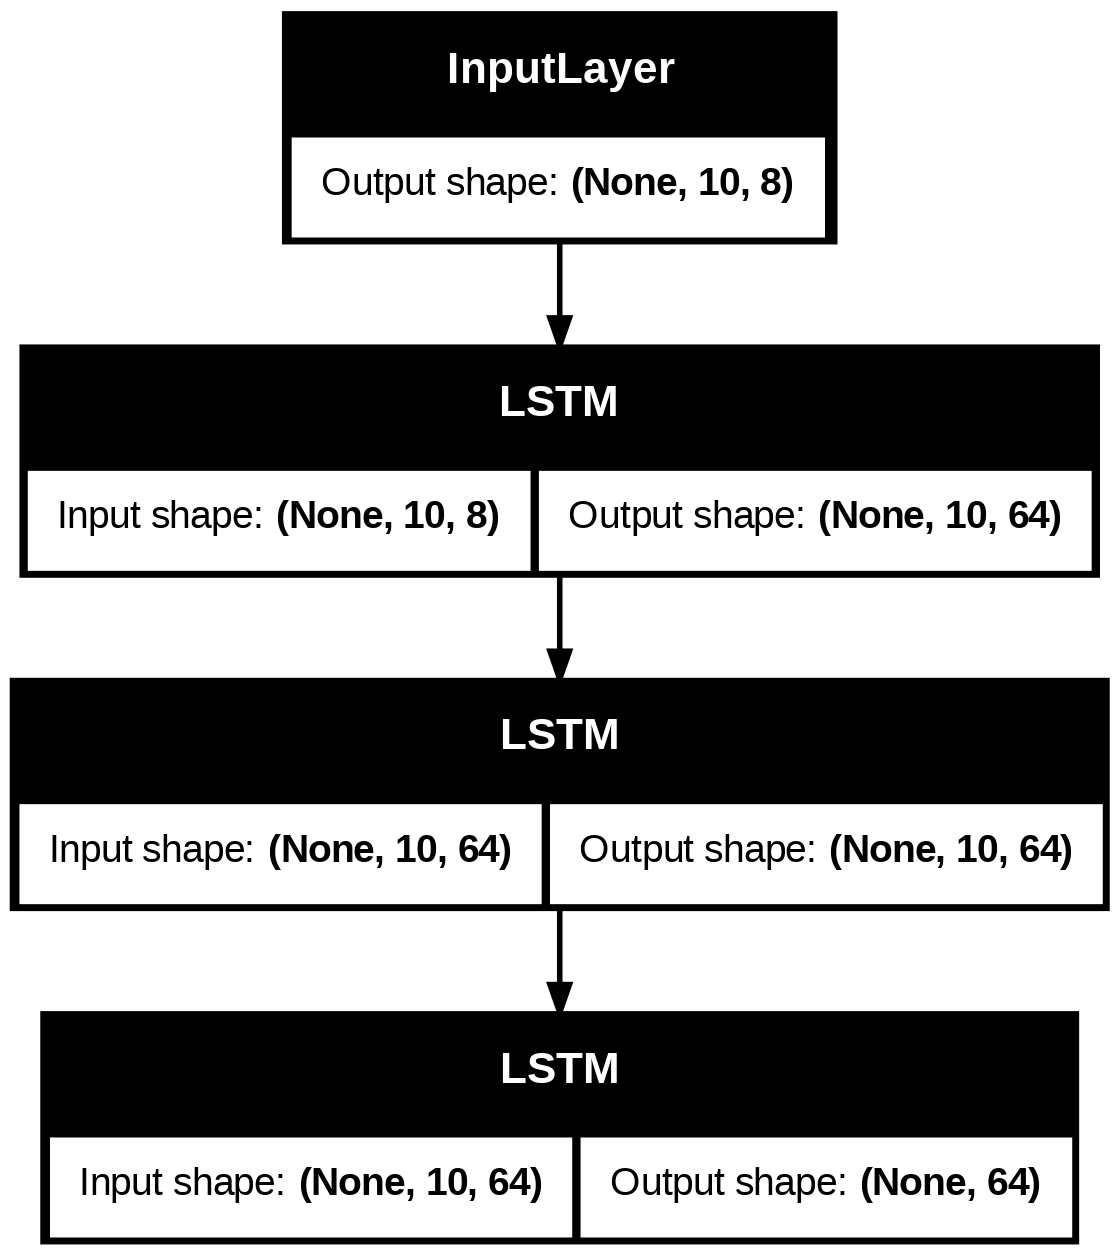

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

这是在演示 双向 LSTM（Bidirectional LSTM） 的搭法，以及为什么堆叠时第一层要 return_sequences=True。

In [6]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,242 (309.54 KB)

 Trainable params: 79,242 (309.54 KB)

 Non-trainable params: 0 (0.00 B)

什么时候用 BiLSTM？

文本、序列标注、离线语音/序列任务：上下文两边都可见 → 常更好。

在线/实时场景（只能看过去，不能看未来）→ 不能用双向。

# Time Series Data Processing

## Sliding Windows

A sliding window is a technique used to create input-output pairs from time series data. It moves a fixed-size window over the time series data to extract subsequences as input features and the corresponding next value(s) as the target(s). The window size determines the number of past time steps to use as input features, and the horizon determines the number of future time steps to predict.


<img src="https://i.ibb.co/5nvJQB4/split-window.png" alt="cnn" border="0">

We will define two `create_windows` functions, one for `tf.data.Dataset` and another for NumPy, to create input-output pairs from the time series data using sliding windows.


For example if  `data = [0,1,2,3,4,5,6]` :

If we have `window_size=3`, and `horizon=2`, we use **windows of size 3** for predicting **2 steps ahead**.

we are going to use `[0,1,2] (length=window_size=3)` to predict `4`,

We need too create a training data like
```python
[0,1,2], 4
[1,2,3], 5
[2,3,4], 6
```


滑动窗口（Sliding Window）：把一条时间序列切成许多「小片段」当作模型输入，再用片段后面的值当作标签去预测。

核心概念：

窗口长度 window_size / input width：作为输入的过去步数。例：看过去 6 步去预测下一步。

预测跨度 horizon / shift：要预测离当前窗口多少步之后的点。例：预测 2 步后。

标签宽度 label width：一次要预测几个连续未来点。例：预测接下来的 3 个点。

步长 stride：窗口每次向前移动几步（通常为 1，会产生重叠样本）。

直观例子
给定序列 data = [0,1,2,3,4,5,6]：

若 window_size=3、horizon=1、label_width=1
产生的 (X→y) 样本：

[0,1,2] → 3

[1,2,3] → 4

[2,3,4] → 5

[3,4,5] → 6

若 window_size=3、horizon=2、label_width=1

[0,1,2] → 4

[1,2,3] → 5

[2,3,4] → 6

若 window_size=6、horizon=1、label_width=1（图里的思路）

[t0..t5] → t6

与 LSTM 输入的形状

模型收到的是形状 (batch, timesteps, features) 的张量：

timesteps = window_size

features 是每个时间步的特征维度（单变量=1，多变量>1）。

如果是多步预测（label_width>1），标签形状通常是 (batch, label_width, target_dim)；若最后用 return_sequences=False 的 LSTM + Dense，也可以把多步预测改成一次性输出向量 (batch, label_width * target_dim)。

Numpy 版 create_windows_np

In [7]:
def create_windows_np(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray): Time series data with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Shuffle the windows or not.

    Returns:
    tuple: A tuple containing the input-output pairs (windows, targets) as NumPy arrays.
    """


     """
    data: 一维时间序列（np.ndarray）
    window_size: 作为输入的过去步数
    horizon: 要预测的“未来第几步”（步长）
    shuffle: 是否把样本顺序打乱
    """

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1): ## 能取到的“起点” i：最后一个可用起点是 len(data) - window_size - horizon
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


    #X[i] 是长度 window_size 的片段；y[i] 是紧跟在片段后的第 horizon 个点。


shuffle=True 会在样本维度打乱 (X, y) 对的顺序（不改变每对内部的时序）。

形状：返回的 X 是 (num_samples, window_size)，y 是 (num_samples,)。如果要喂 RNN，需要把 X 变成 (num_samples, window_size, features)，单变量时 features=1。

Numpy 版测试用例（验证切窗正确）

In [8]:
X_trial, y_trial = create_windows_np(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)
for ind in range(len(y_trial)):
    print(X_trial[ind, :], y_trial[ind])

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


tf.data 版 create_windows_tf 用于更长的数据集

In [9]:
def create_windows_tf(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (np.ndarray): Time series data with with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """

    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (window[:window_size], window[-1]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

ts_dataset = create_windows_tf(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)

for window, target in ts_dataset:
    print(window.numpy(), target.numpy())

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


from_tensor_slices(data)：把一维序列变成按时间步切的 Dataset。

.window(window_size + horizon, shift=1, drop_remainder=True)：

生成滑动子窗口，每个长度固定为 window_size + horizon；

shift=1 表示窗口每次向前挪 1 步；

drop_remainder=True 丢弃末尾不够长的窗口。

.flat_map(...batch...)：把每个子窗口（本来是一个小 Dataset）转成一个张量。

.map(lambda w: (w[:window_size], w[-1]))：前 window_size 步当输入，最后一个元素当标签（等价于 horizon=1 的单点预测；你这里的 window(window_size + horizon) 决定了最后一个就是“距离窗口末尾 horizon 的点”）。

# Simple univariate time series forecasting with RNN

We will use a sine wave as our example time series data. We will generate 1000 data points with a step of 0.1.

#用 RNN 做单变量时间序列预测
我们将使用一条正弦波作为示例时间序列数据。我们将以 0.1 的步长生成 1000 个数据点。

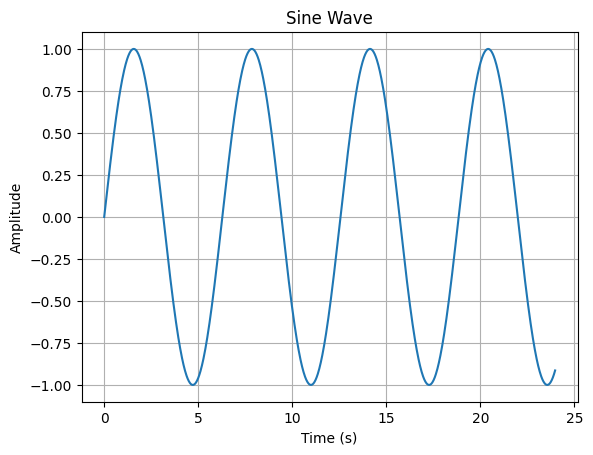

In [10]:
# Generate sine wave data
t = np.arange(0, 24, 0.02)
y = np.sin(t)

# Plot the sine wave
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sine Wave')
plt.grid(True)
plt.show()

In [11]:
# train test split
train_size = int(len(y) * 0.8)
ts_train, ts_test = y[:train_size], y[train_size:]
print(ts_test.shape)

(240,)


y[:train_size]：从开头到第 train_size-1 个元素（不含后面的），作为训练集 → ts_train

y[train_size:]：从第 train_size 个元素一直到结尾，作为测试集 → ts_test

也就是前80%当训练，后20%当测试（你的 train_size = int(len(y)*0.8)）。

In [12]:
window_size = 10
horizon = 2
X_train, y_train = create_windows_np(ts_train, window_size, horizon=2, shuffle=True)
X_test, y_test = create_windows_np(ts_test, window_size, horizon=2, shuffle=False)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (949, 10)
Test shape: (229, 10)



样本数公式：num = len(series) - window_size - horizon + 1
训练集：960 - 10 - 2 + 1 = 949 → X_train.shape = (949, 10)
测试集：240 - 10 - 2 + 1 = 229 → X_test.shape = (229, 10)

每个 X 窗口长度是 10；y 是窗口后第 2 步的值。

In [13]:
inputs_shape = (window_size, 1)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, 1))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=7,
    validation_data=(X_test, y_test)
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2789 - val_loss: 0.1744
Epoch 2/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1043 - val_loss: 0.0512
Epoch 3/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0280 - val_loss: 0.0171
Epoch 4/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0130
Epoch 5/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 0.0119
Epoch 6/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 0.0107
Epoch 7/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - val_loss: 0.0095


这段模型在做什么

输入层：Input(shape=(window_size, 1))
形状 (None, 10, 1) 表示：batch批大小不定、timesteps时间步 10、feature每步 1 个特征（单变量序列）。

LSTM(8, return_sequences=False)
只输出最后一个时间步的隐藏状态 → 形状 (None, 8)。这一层把 10 步信息“压缩”成一个 8 维表示。

Dense(1)
把 8 维表示映射为一个标量，做单步回归预测 → 形状 (None, 1)。

参数量为什么是这些？

LSTM 参数数公式（默认有输入门、遗忘门、输出门、候选，共 4 组）：
params = 4 * [ units * (units + input_dim) + units ]
这里 units=8, input_dim=1：
= 4 * [ 8*(8+1) + 8 ] = 4 * (72 + 8) = 320 ✅

Dense(1) 参数：8*1 + 1(bias) = 9 ✅

In [14]:
# Use the trained RNN model to make predictions on the test data.
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


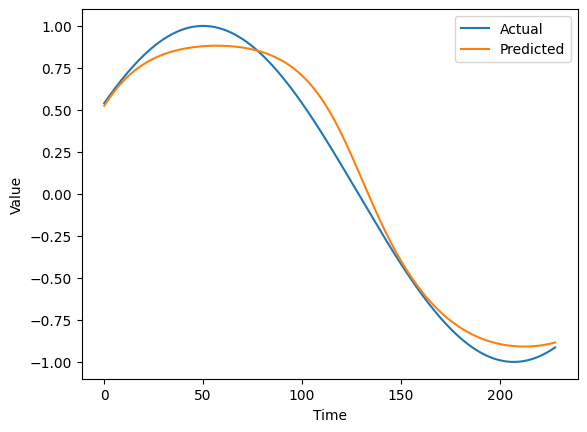

In [15]:
# visualize the actual vs. predicted values.
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

window 和 timestep的关系：

timestep（时间步）：序列里的一个位置（t=0、t=1、…）。

window（窗口）：把连续的多个时间步拼成的一段子序列，长度通常记作 window_size。

在你用滑动窗口做建模时，每个样本的输入就是一个窗口（例如 10 个时间步）。

因此 Keras 的输入形状 (timesteps, features) 里，timesteps = window_size（当你用固定长度窗口时）。

# Simple multivariate time series forecasting with RNNs

#用 RNN 进行多变量时间序列的简单预测

multivariate 指的是每个时间步有多个特征/变量（比如温度、湿度、风速一起），用它们共同去预测目标。

In [16]:
import pandas as pd


def create_windows_multivariate_np(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray or pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tuple: A tuple containing the input-output pairs (X, y) as NumPy arrays.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size+horizon-1, target_col_idx])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


def create_windows_multivariate_tf(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (
        window[:window_size], window[-1, target_col_idx]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

In [17]:
# Generate synthetic multivariate time series data
t = np.arange(0, 24, 0.01)
y1 = np.sin(0.1 * t)
y2 = 0.5 * np.sin(0.2 * t)
data = np.vstack((y1, y2)).T
print(data.shape)

(2400, 2)


“sinosoide”是西班牙语，指正弦波（英语：sine wave / sinusoid）。


典型形式：y=Asin⁡(ωt+φ)+by = A \sin(\omega t + \varphi) + by=Asin(ωt+φ)+b


AAA：幅度（越大波峰越高）


ω\omegaω：角频率（ω=2πf\omega = 2\pi fω=2πf）


fff：频率，T=1/fT=1/fT=1/f 为周期


φ\varphiφ：相位（决定起点位置）


bbb：直流偏置（整体上移/下移）




特点：周期性、平滑、对称，在信号处理、物理、时间序列教材里常用来做示例或合成数据。



这是在生成一条“多变量时间序列”的合成数据，每个时间步有两个特征（两条不同的正弦波）。
逐行解释：


t = np.arange(0, 24, 0.01)
生成时间轴从 0 到 24（不含 24），步长 0.01 → 共 2400 个时间步。


y1 = np.sin(0.1 * t)
第一个特征：频率较低、幅度 1 的正弦波。


y2 = 0.5 * np.sin(0.2 * t)
第二个特征：频率更高、幅度 0.5 的正弦波。


data = np.vstack((y1, y2)).T
把两条序列按列堆叠并转置成形状 (2400, 2) 的数组：


2400 = 时间步数


2 = 每个时间步的特征数（features）




打印输出 (2400, 2) 说明：这就是一个多变量序列，后续做滑动窗口时输入形状会是 (batch, window_size, 2)，其中 window_size 是你选的时间窗口长度。

用**合成数据（synthetic data）**主要是为了一个“可控的练兵场”。在时序 + RNN 里它有这些好处：

可控、可解释

我们知道真实规律（这里是两条正弦），预测“该达到的上限”很清楚。

便于判断：模型不准是因为代码/形状/损失不匹配，还是因为数据本身太噪。

快速验收管线

验证滑动窗口、(batch, timesteps, features) 形状、mask、标准化、callbacks 等是否都正确。

跑不通时更容易定位问题（例如 NaN、泄漏、维度错位）。

基准与对照

作为 baseline：先在简单周期信号上达到合理误差，再迁移到真实数据。

便于对比不同模型/超参（LSTM vs GRU、窗口/步长/学习率）的趋势。

隐私与合规

不涉及机密和个人数据，分享代码/笔记本更方便。

压力测试

可以主动加噪声、相移、异常点、缺失值，观察鲁棒性。

什么时候该上真实数据？

管线在合成数据上能稳定学到（例如 MAE 很小、能跟上相位）后，就换真实数据；

再做严格的时间切分与无泄漏的标准化，并根据业务指标评估效果。

小结：合成数据不是目的，是“把工具调好”的手段。等到形状、窗口、损失都确认 OK，再到真实场景里比拼模型能力。

In [18]:
# train test split
train_size = int(data.shape[0] * 0.8)
ts_train, ts_test = data[:train_size], data[train_size:]
print(ts_test.shape)

(480, 2)


data 形状是 (T, 2)：T 个时间步、每步 2 个特征（两条正弦波）。

前 80% 做训练，后 20% 做测试。

In [19]:
window_size = 10
horizon = 10


train_ds = create_windows_multivariate_tf(
    ts_train, window_size, horizon, target_col_idx=0, shuffle=True)

test_ds = create_windows_multivariate_tf(
    ts_test, window_size, horizon, target_col_idx=0, shuffle=False)

train_ds = train_ds.batch(64)
test_ds = test_ds.batch(100)

target_col_idx=0：目标是第 0 个特征在 窗口末端t+10 的值（单点预测）。

每个样本输入窗口包含最近 10 个时间步、两列特征。

In [20]:
for window, target in train_ds:
    print(window.numpy().shape, target.numpy().shape)
    break

(64, 10, 2) (64,)


In [21]:
num_features = 2 # (y1, y2)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, num_features))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    train_ds,
    epochs=12,
    validation_data=test_ds
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 8)              │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
     27/Unknown 1s 4ms/step - loss: 0.4287

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4126 - val_loss: 0.1272
Epoch 2/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0474 - val_loss: 9.1179e-04
Epoch 3/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 9.4116e-04
Epoch 4/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 5.3925e-04
Epoch 5/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 4.9101e-04
Epoch 6/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 3.6672e-04
Epoch 7/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 2.8693e-04
Epoch 8/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 3.2349e-04
Epoch 9/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 4.0341e-04
Epoch 10/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 4.6177e-04
Epoch 11/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 5.0699e-04
Epoch 12/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


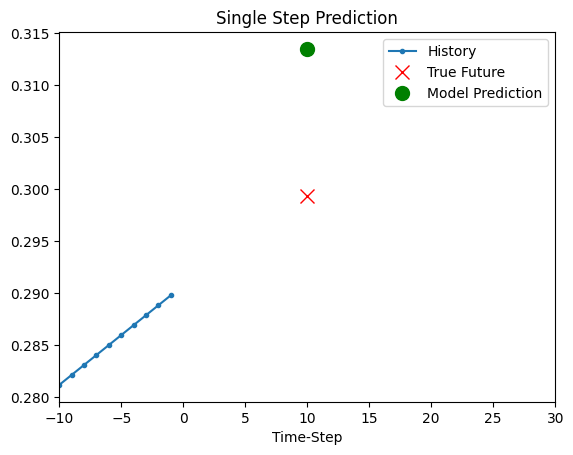

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


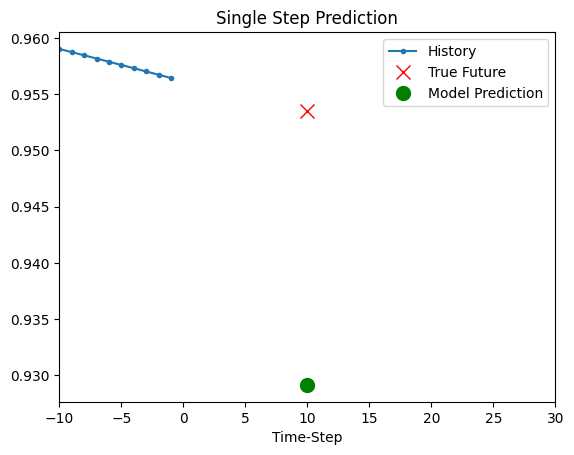

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


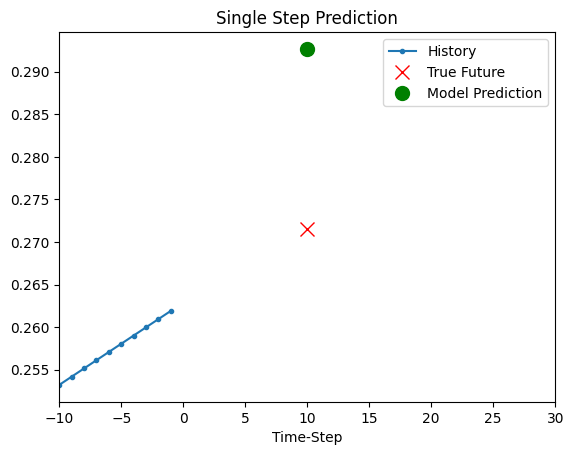

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


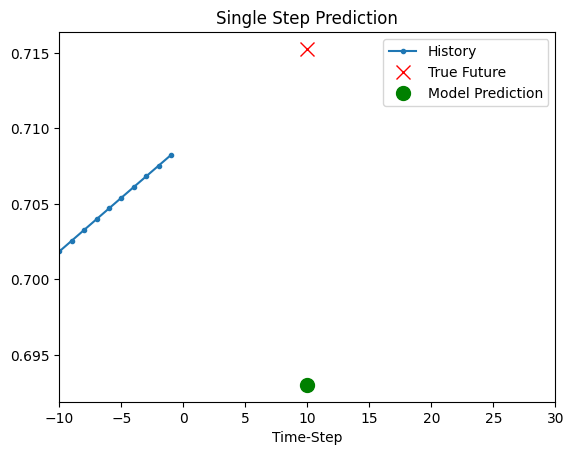

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


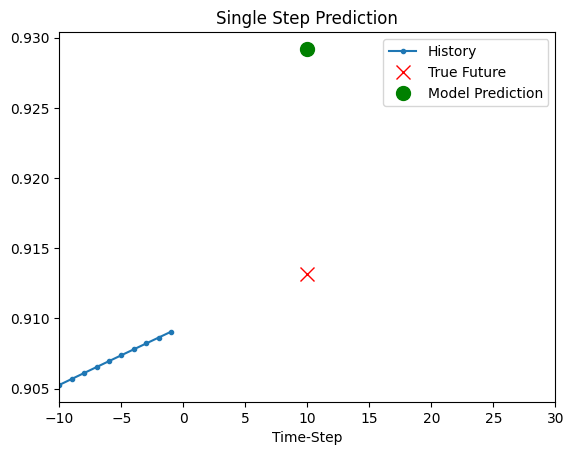

In [22]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in train_ds.take(5):
    x_in = x.numpy()
    y_in = y.numpy().flatten()
    pred = model.predict(x)
    show_plot(
        [x_in[0,:, 0], y_in[0], pred.flatten()[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


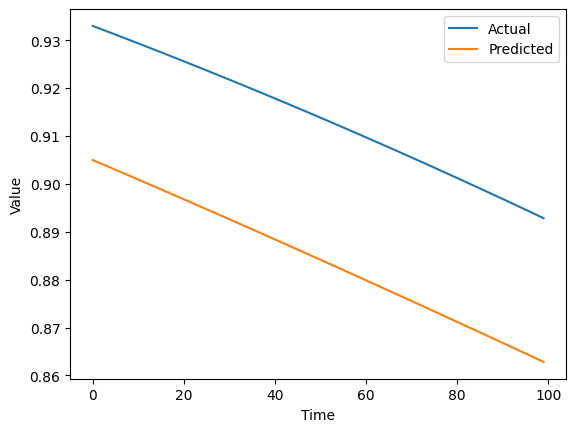

batch:  1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


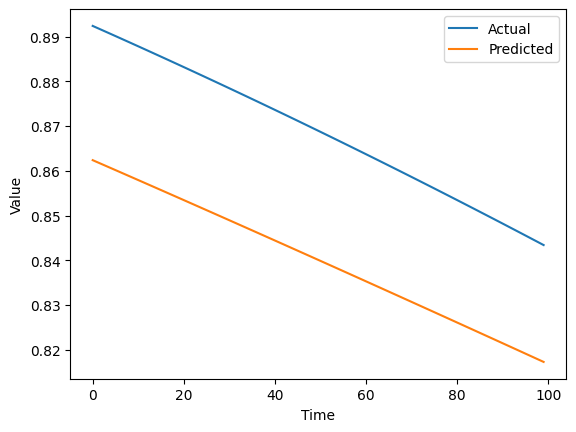

batch:  2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


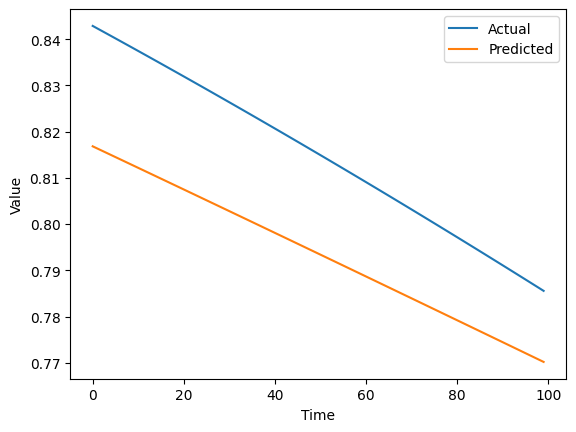

In [23]:
for i, (x, y) in enumerate(test_ds):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [24]:
from zipfile import ZipFile
import os
from datetime import datetime
import pandas as pd



uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()

def parse_dates(x):
    return datetime.strptime(x, '%d.%m.%Y %H:%M:%S')

csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, parse_dates=['Date Time'], date_parser=parse_dates)
df.head()

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-1732587478.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(csv_path, parse_dates=['Date Time'], date_parser=parse_dates)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

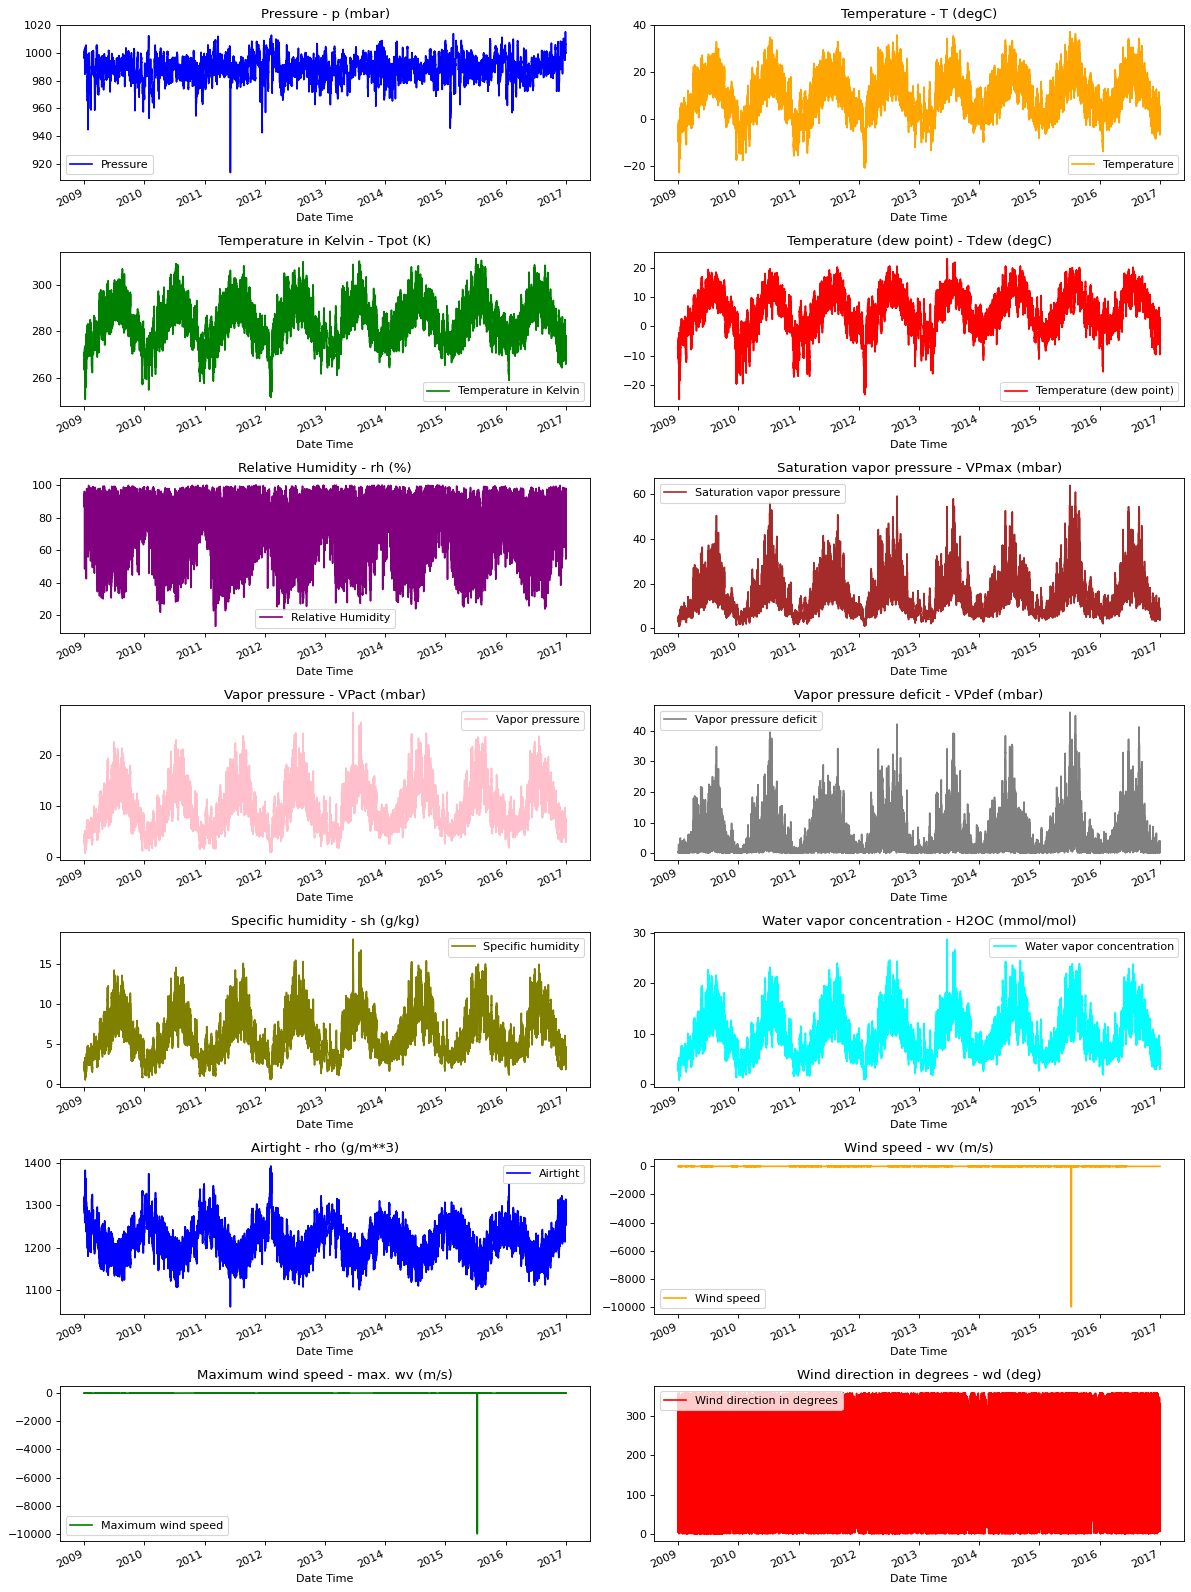

In [25]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

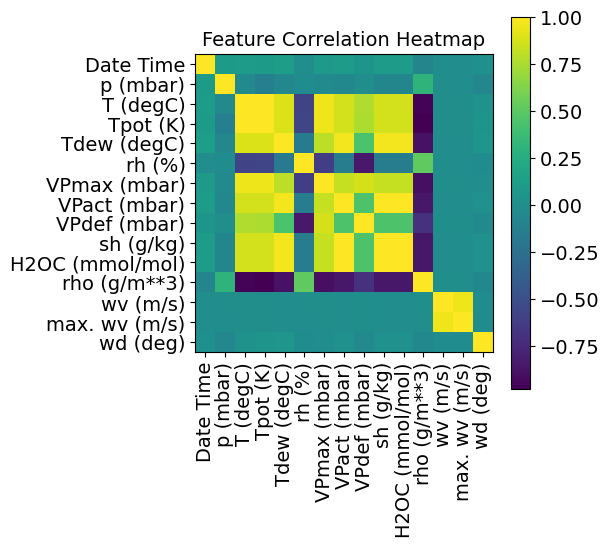

In [26]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [27]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

### Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

我们选取约 30 万 个数据点用于训练。原始观测每 10 分钟记录一次，也就是每小时 6 次。由于在 60 分钟内不期望有剧烈变化，我们会重采样为每小时一个点。这一步通过 timeseries_dataset_from_array 工具里的 sampling_rate 参数完成。

我们跟踪过去 720 个时间步的数据（720/6 = 120 小时）。这些数据将用于预测在 72 个时间步之后的温度（72/6 = 12 小时）。

由于各个特征的数值范围不同，我们在训练神经网络之前做归一化/标准化，把特征值限制到 [0, 1] 的范围（做法是对每个特征减去均值并除以标准差）。

数据中的 71.5% 将用于训练模型，即 300,693 行。可以通过 split_fraction 参数来调整这个百分比。

模型会看到前 5 天的数据，即 720 个按每小时采样的观测。第 72 个观测（12 小时 × 每小时 6 次观测）对应的温度将作为标签使用。

In [28]:
df = df.set_index('Date Time')
## resample by the mean of hour values
df =df.resample('1h').mean().fillna(method='ffill') #
df.head()

/tmp/ipython-input-3551573031.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df =df.resample('1h').mean().fillna(method='ffill') #


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333




这段在做按小时重采样并补齐缺失，用于把原始（比如每10分钟一次）的气象数据变成每小时一个样本，方便做时序建模。

逐行解释与作用：

df = df.set_index('Date Time')
把时间列设为索引，后面才能按时间频率做重采样。

常见前置：df['Date Time'] = pd.to_datetime(df['Date Time']); df = df.sort_values('Date Time')

df = df.resample('1h').mean()
以1 小时为频率，把这一小时内的多条记录聚合为均值。

作用：把“每10分钟×6笔/小时”的数据压成“每小时1笔”，降低噪声与采样率。

也可以用 .agg({'T':'mean','wd':'median', ...}) 对不同列用不同统计。

.fillna(method='ffill')（前向填充）
对重采样后出现的缺口/NaN，用最近一次非空值向前填补。

适合缓慢变化或缺口很短的传感器数据；

但对累加量/突变变量谨慎使用，必要时改用 interpolate() 或不填。

In [29]:
#Use only important features
df_0 = df.copy()
df = df[selected_features].copy()

In [30]:
df.values.shape

(70129, 9)

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [31]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.290000,0.670000,150.093333


### Training and validation datasets



In [32]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12
#之后每个训练样本的 X 都是最近 6 小时的多变量片段；y 是 12 小时后的一个标量目标。

batch_size = 128

columns = df.columns
# Get the target column index
target_col_idx = columns.get_loc('T (degC)')
#在多变量特征里选温度列 'T (degC)' 的 列索引，用于做标签（y）。

#生成滑动窗口数据集（tf.data 版）
dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

#每个元素是 (window, target)：

#window 形状：(window_size, n_features)

#target 形状：标量（对应 horizon 后、target_col 的值）

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)
#批后每个 window 的形状会变成 (batch, window_size, n_features)。

#抽一个批，查看输入/目标的真实形状
for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 9)
Target shape: (128,)


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

两个核心API做什么

Dataset.cache()

第一次把数据读/计算出来后，就缓存在内存（默认）或指定文件（cache("path")）里。

之后每个 epoch 直接从缓存取，避免重复 I/O 与重复计算。

数据太大装不下内存时，可用 cache("my.cache") 落盘。

Dataset.prefetch(buffer_size=AUTOTUNE)

让“数据准备（CPU）”与“模型训练（GPU/TPU）”并行：训练当前 batch 的同时，后台准备下一个 batch。

AUTOTUNE 让 TF 自动选择合适的缓冲大小。

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

tf.data 的性能优化：用 cache() 和 prefetch() 让数据加载不卡训练。

### Training

#### Normalization layer
We can normalize the features with [Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization).

```python
tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, mean=None, variance=None, **kwargs
)
```

```python
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(dataset_train.map(lambda x, y: x))

```



`adapt` computes mean and std of the train data and store them as the layer's weights. `adapt`
 should be called before fit, evaluate, or predict.



这是在用 Keras 的 Normalization 层做“按特征（feature-wise）标准化”。核心点就两句：

Normalization(axis=-1)：把最后一维（features 轴）按「(x - 均值) / 标准差」标准化。对时序输入 (batch, timesteps, features)，它会对每个特征列统计整体均值/方差（把 batch、timesteps 当作样本维度），不会打乱时间顺序。

norm.adapt(dataset_train.map(lambda x, y: x))：只用训练集的 X来估计均值和方差，防止数据泄漏。adapt 需要在 fit/evaluate/predict 之前调用一次。

Normalization(axis=-1) + adapt(训练集X)，把时序的每个特征列标准化，后面 LSTM 就能更稳更快地收敛。

In [35]:
norm = tf.keras.layers.Normalization(
    axis=-1, dtype=None, mean=None, variance=None
)
norm.adapt(dataset_train.map(lambda x, y: x))

print('Unnormalized row: ', df.iloc[:1].values)
print('Normalized row: ', norm(df.iloc[:1]))
print('Normalized df, mean row: ',norm(df.values).numpy().mean(1))
print('Normalized df, std row: ',np.std(norm(df.values).numpy(), 1))

Unnormalized row:  [[ 9.965280e+02 -8.304000e+00  3.260000e+00  2.020000e-01  1.910000e+00
   1.309196e+03  5.200000e-01  1.002000e+00  1.744600e+02]]
Normalized row:  tf.Tensor(
[[[ 0.9488589  -2.0142405  -1.3145648  -0.79072905 -1.4998467
    2.2535021  -1.1247861  -1.1622005   0.01345505]]], shape=(1, 1, 9), dtype=float32)
Normalized df, mean row:  [[ 0.06744271  0.03871625  0.02783933  0.00901052  0.0392657  -0.021886
  -0.3116564  -0.22941801  0.01771476]]
Normalized df, std row:  [[ 1.0076      0.9727965   1.0055249   1.0171734   0.99273664  0.97563803
  42.949776   30.31656     0.9848102 ]]


#### Create the model

用标准化层 + SimpleRNN 做单点回归预测。

In [53]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


In [54]:
num_features =  9
inputs_shape = (window_size, num_features)

inputs = keras.layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
rnn_out = keras.layers.SimpleRNN(32)(inputs_norm)
outputs = keras.layers.Dense(1)(rnn_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 6, 9)           │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,396 (5.46 KB)

 Trainable params: 1,377 (5.38 KB)

 Non-trainable params: 19 (80.00 B)

We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [56]:
# path_checkpoint = "model_checkpoint.h5"
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    378/Unknown 8s 10ms/step - loss: 92.4281
Epoch 1: val_loss improved from inf to 23.47324, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 91.7069 - val_loss: 23.4732
Epoch 2/25
371/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.3738
Epoch 2: val_loss improved from 23.47324 to 17.36676, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 19.3242 - val_loss: 17.3668
Epoch 3/25
367/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.1077
Epoch 3: val_loss improved from 17.36676 to 15.81376, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.0860 - val_loss: 15.8138
Epoch 4/25
376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.6401
Epoch 4: val_loss improved from 15.81376 to 14.71658, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.6338 - val_loss: 14.7166
Epoch 5/25
373/384 ━━━━━━━━━━━━━━━━━━━━ 0s 

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


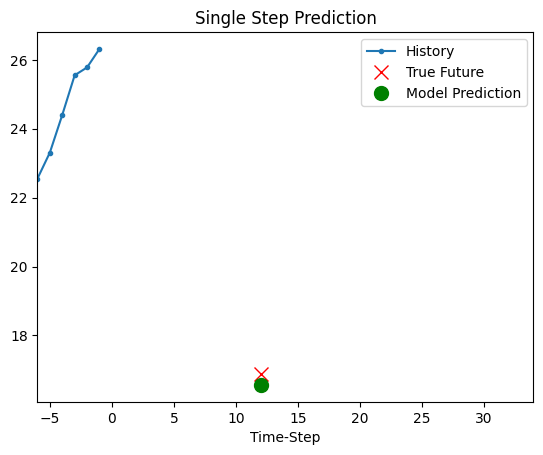

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


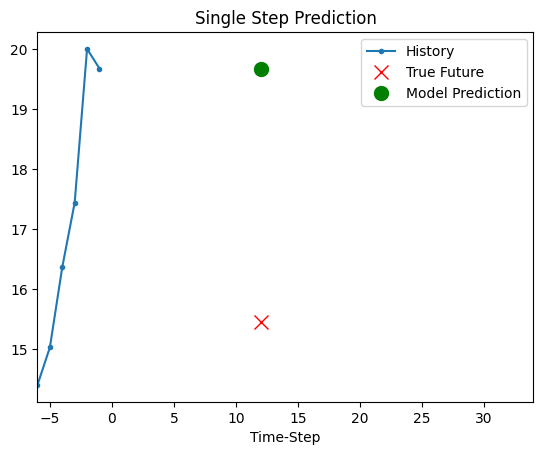

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


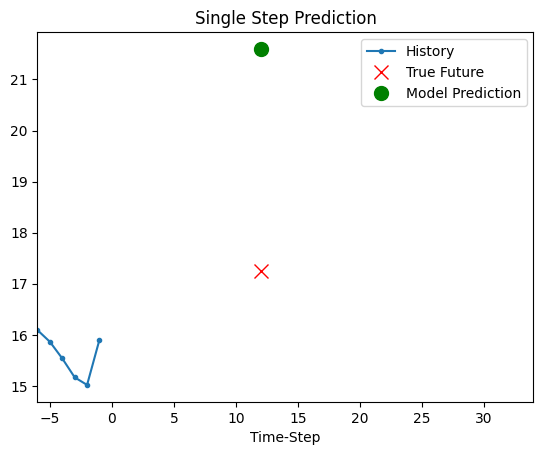

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


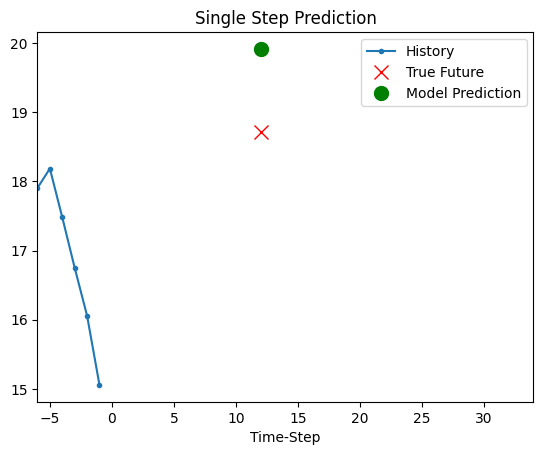

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


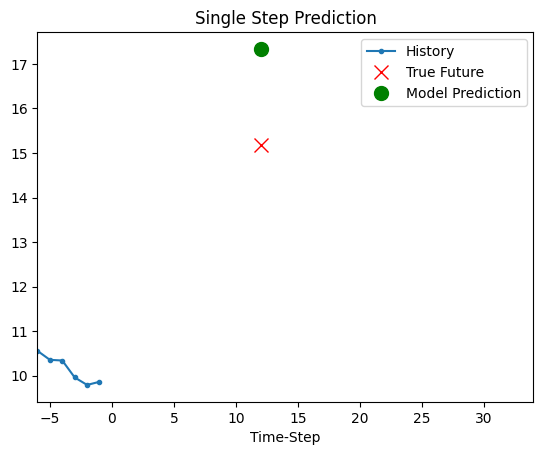

In [57]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


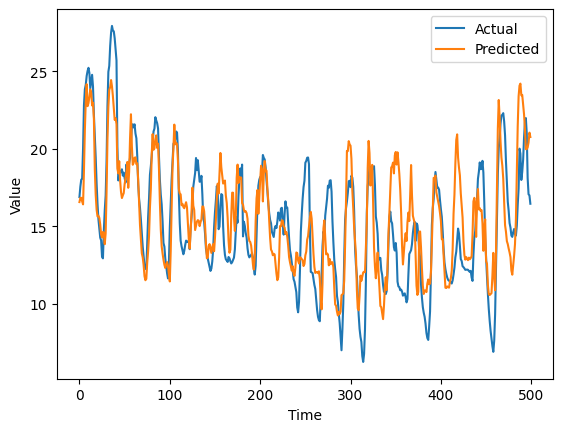

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


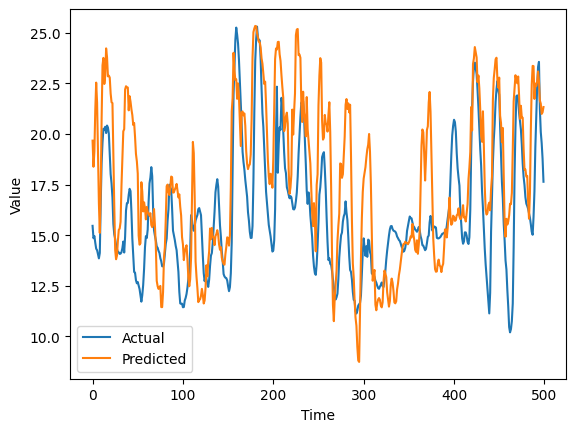

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


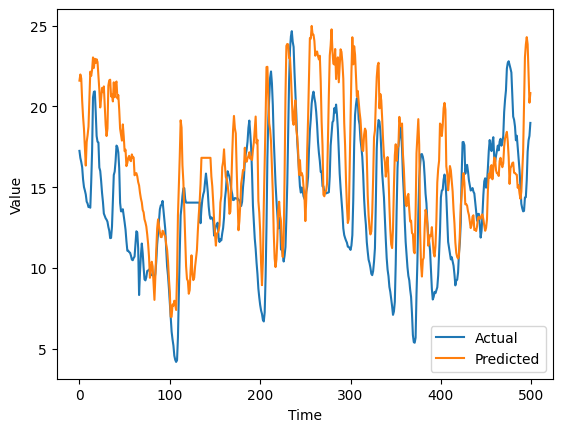

In [58]:

for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

#### Question 1:  Change the `keras.layers.SimpleRNN` layer to `keras.layers.LSTM` and to `keras.layers.GRU` and compare the results
You can also set the `recurrent_dropout` parameter

```python
tf.keras.layers.x(
    units,
    dropout=0.0,
    recurrent_dropout=0.0)
```

In [60]:

num_features = 9
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
lstm_out = layers.GRU(64)(inputs_norm)

outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [61]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 66.4036 - val_loss: 17.2178
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 15.2727 - val_loss: 15.8785
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13.3101 - val_loss: 14.2031
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.4786 - val_loss: 14.0951
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.1482 - val_loss: 13.3667
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.0286 - val_loss: 12.8578
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 11.6537 - val_loss: 13.0620
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 11.2193 - val_loss: 12.5360
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 11.0082 - val_loss: 12.2675
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.8201 - val_loss: 11.9109
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.5700 - val_loss: 12.0111
Epoch 12/25
384/384 ━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


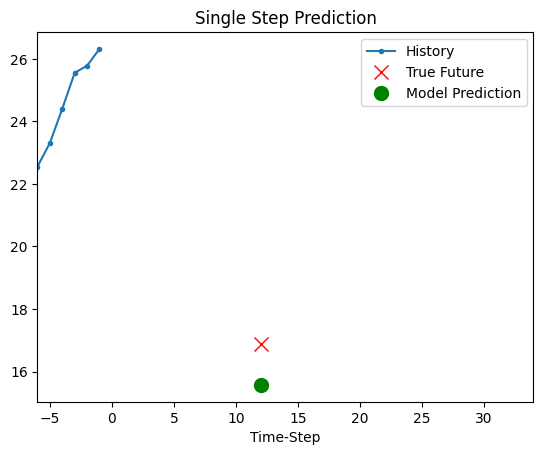

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


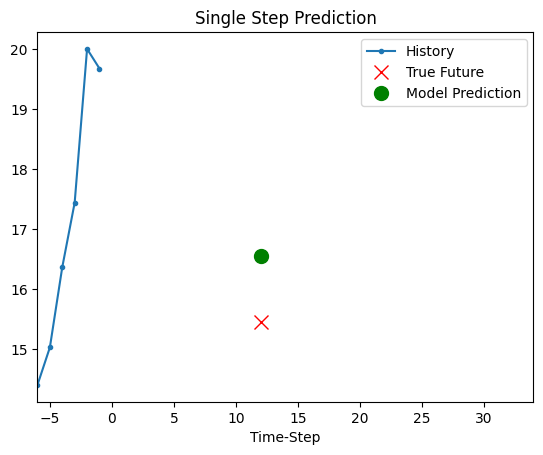

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


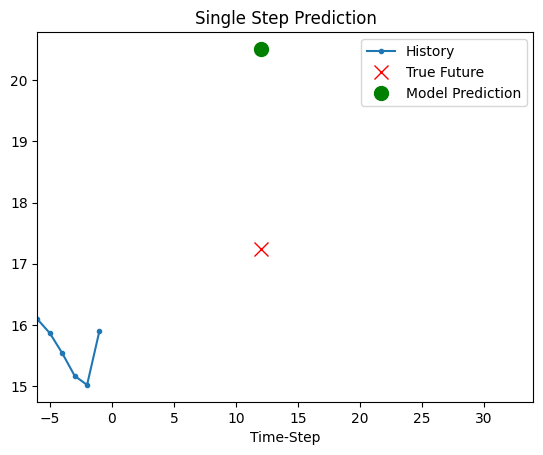

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


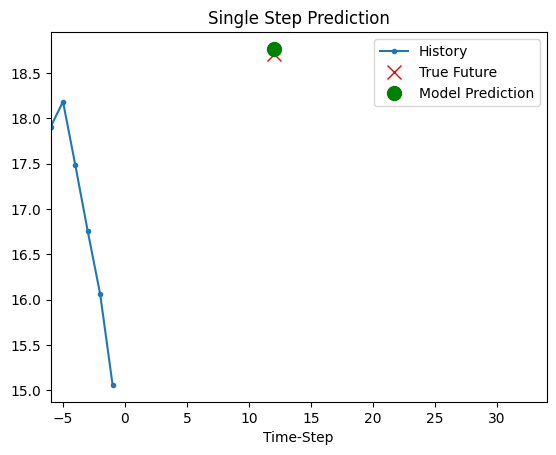

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


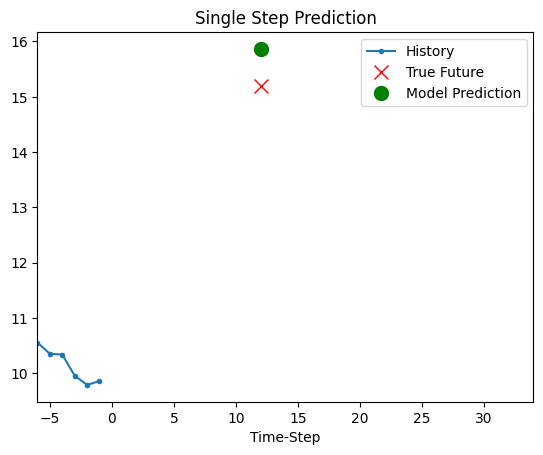

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


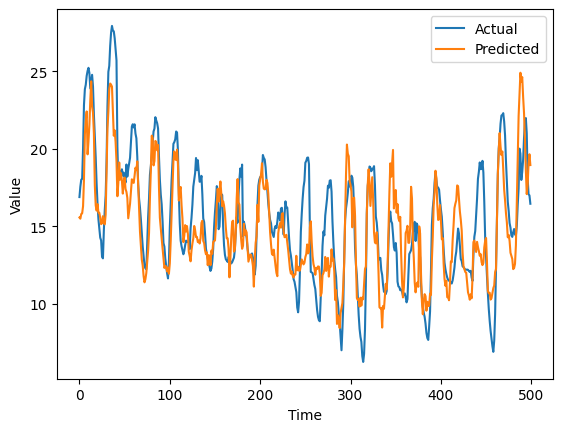

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


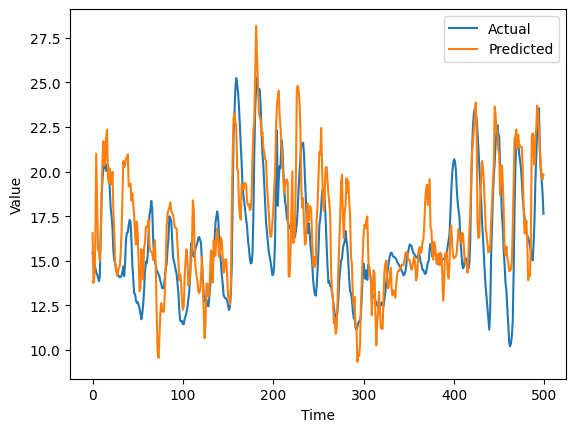

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


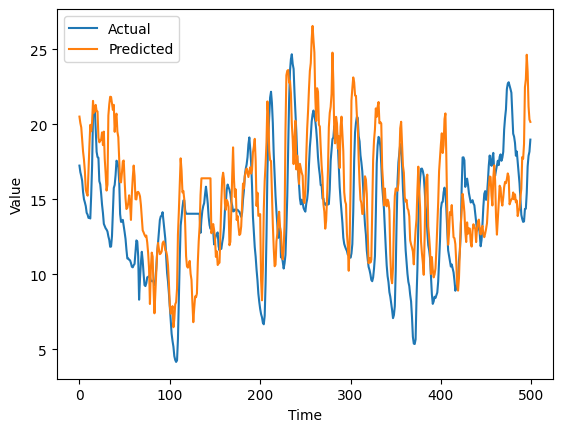

In [62]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Feature Engineering

Wind velocity
One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [63]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
df['wv (m/s)'] = wv

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['max. wv (m/s)'] = max_wv


wv（风速）和 max_wv（最大风速）里 -9999 是占位的坏值/缺失标记，不是物理值。

由于风速不应为负，这里把它们替换为 0。

小提示：写成不触发链式赋值更安全：
df.loc[df['wv (m/s)']==-9999.0, 'wv (m/s)'] = 0.0（同理处理 max. wv (m/s)）。

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [64]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

pop 会返回列并从 DataFrame 中移除（如果想保留原列，改用 df['col'] 读取并不要 pop）。

wd (deg) 是风向（度），先转弧度再用三角函数分解：

𝑊
𝑥
=
speed
⋅
cos
⁡
(
𝜃
)
Wx=speed⋅cos(θ)

𝑊
𝑦
=
speed
⋅
sin
⁡
(
𝜃
)
Wy=speed⋅sin(θ)

同样对最大风速得到 max Wx / max Wy。

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:


Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

这是把时间索引“日期时间”转成可学习的周期特征（日周期 & 年周期）。思路和风向→(cos,sin) 一样，用正弦/余弦消除“0点≈24点”“1月≈12月”的断点。

In [65]:
from datetime import datetime
timestamp_s = df.index.map(datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [66]:
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [67]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [68]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 15)
Target shape: (128,)


In [69]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Question 2:  Use the same model as before and compare the results


In [71]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [72]:
num_features = 15
inputs_shape = (window_size, num_features)

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
## complete the code
lstm_out = layers.GRU(64)(inputs_norm)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [73]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
    372/Unknown 4s 8ms/step - loss: 60.5419

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 59.4185 - val_loss: 8.5687
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.5118 - val_loss: 6.7921
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3552 - val_loss: 6.3719
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.9589 - val_loss: 6.2689
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.6923 - val_loss: 6.0376
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.5554 - val_loss: 5.9814
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.4280 - val_loss: 6.1032
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.3473 - val_loss: 5.8283
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.2043 - val_loss: 5.8451
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1330 - val_loss: 5.7092
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0488 - val_loss: 5.8011
Epoch 12/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


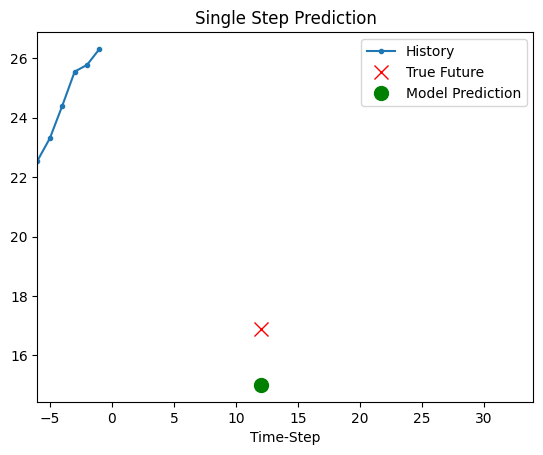

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


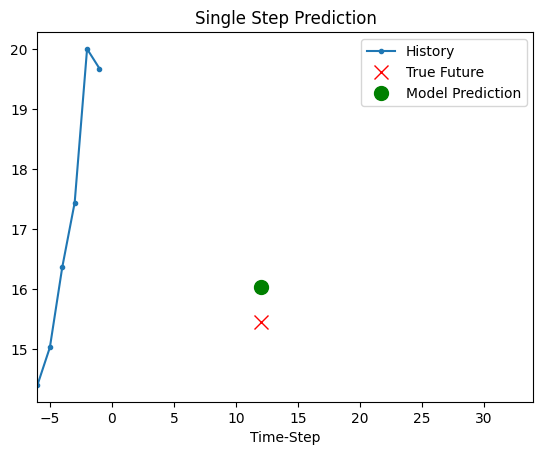

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


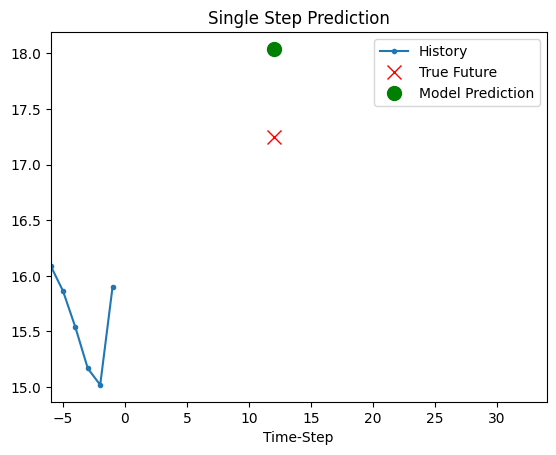

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


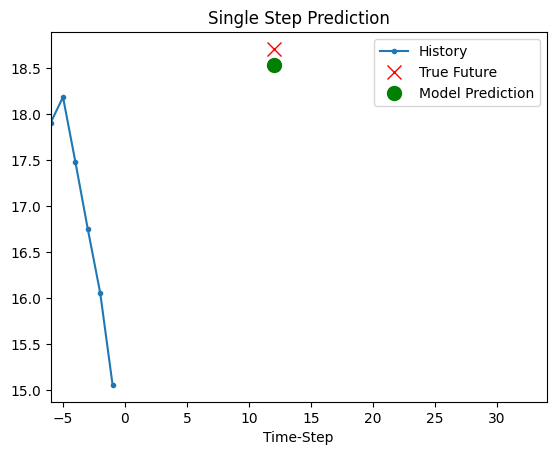

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


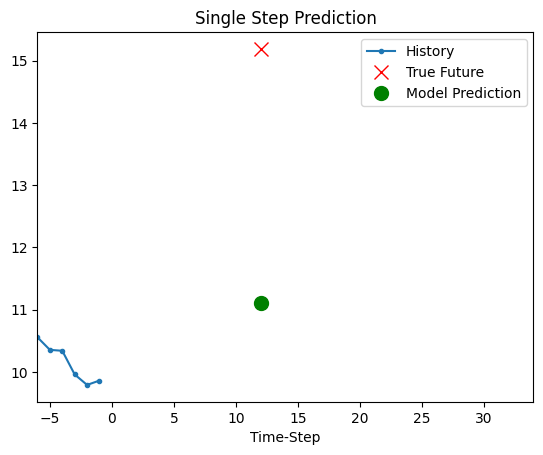

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


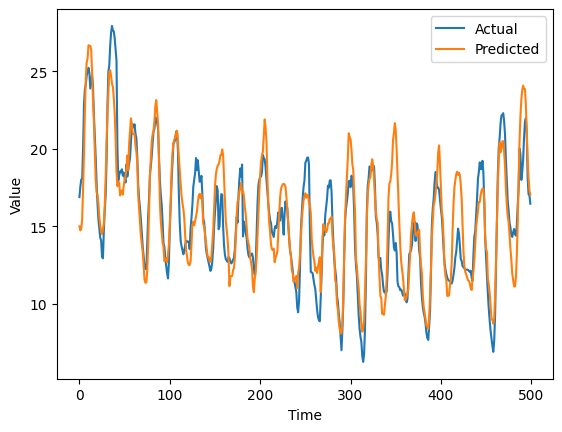

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


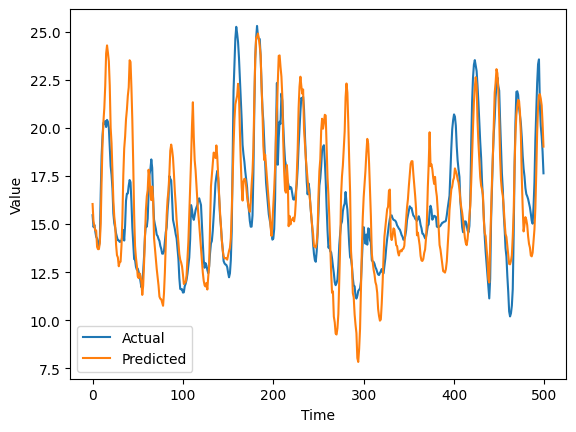

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


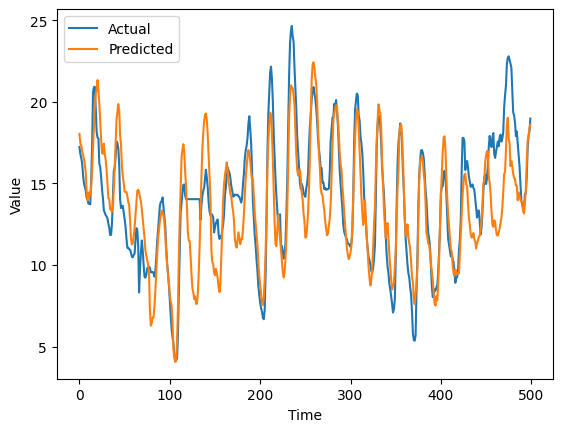

In [74]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 3:  Create a deep model stacking two recurrent layers

In [76]:

num_features = 15
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
l_1 = keras.layers.LSTM(64, return_sequences=True)(inputs_norm)
l_2 = keras.layers.LSTM(64, return_sequences=False)(l_1)

outputs = keras.layers.Dense(1)(l_2)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [77]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 49.6283 - val_loss: 7.7277
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.9214 - val_loss: 6.9794
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.0712 - val_loss: 6.3384
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.6201 - val_loss: 6.0616
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4388 - val_loss: 6.0815
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.3208 - val_loss: 6.0302
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0718 - val_loss: 6.3552
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.9352 - val_loss: 5.9927
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.8689 - val_loss: 6.1404
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6231 - val_loss: 5.9357
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.5303 - val_loss: 6.0087
Epoch 12/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


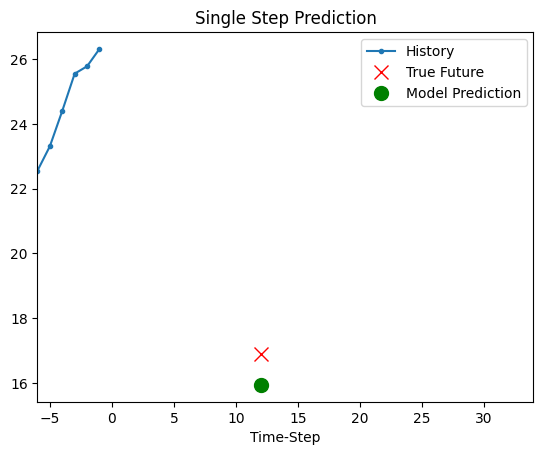

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


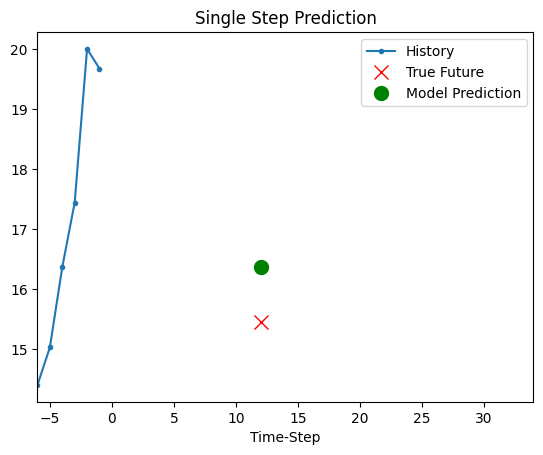

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


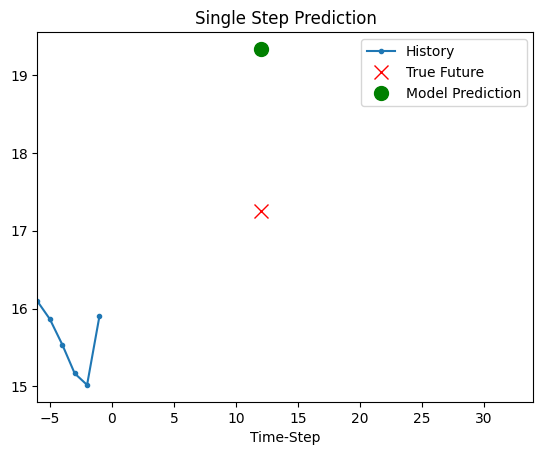

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


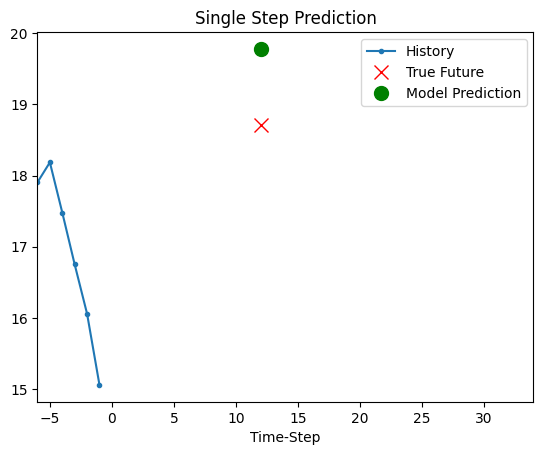

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


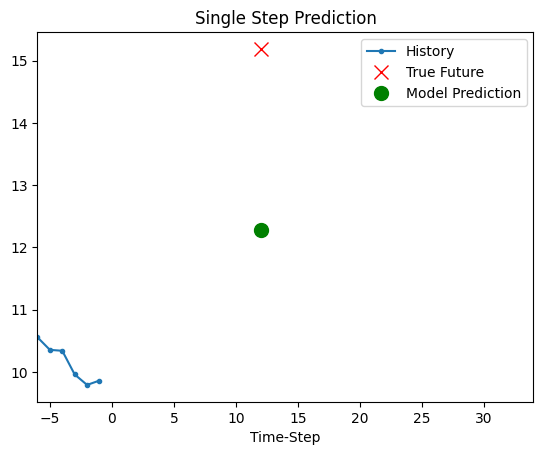

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


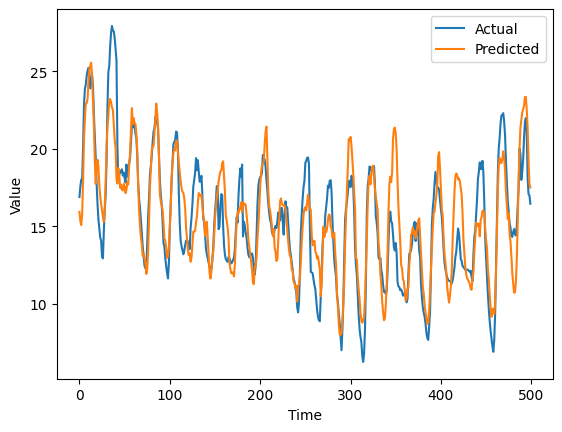

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


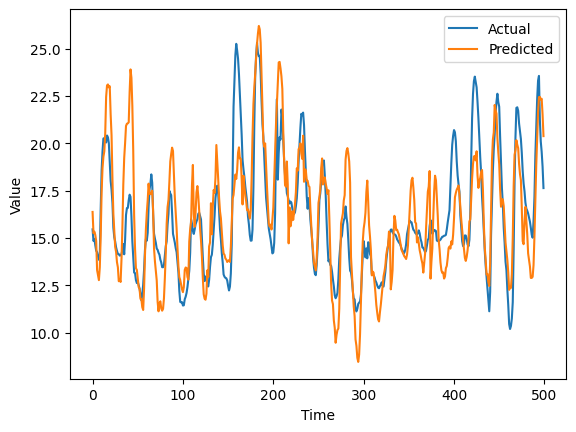

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


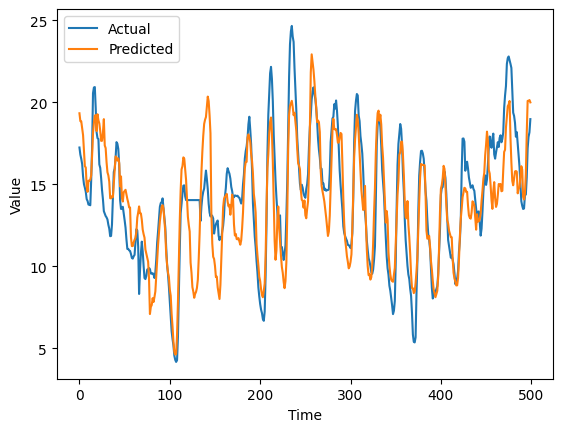

In [78]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 4:  Use `Bidirectional`  layer

```python
layers.Bidirectional(layers.LSTM(64, return_sequences=)
````


In [79]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


inputs = layers.Input(shape=(window_size, num_features))
inputs_norm = norm(inputs)

## complete the code
l_1 = layers.Bidirectional(layers.GRU(64, return_sequences=False))(inputs_norm)

outputs = keras.layers.Dense(1)(l_1)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [80]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 51.6583 - val_loss: 7.2771
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.6618 - val_loss: 6.4321
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.1083 - val_loss: 6.0458
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.5911 - val_loss: 5.8663
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4887 - val_loss: 5.8384
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.3505 - val_loss: 5.7100
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.1950 - val_loss: 5.6131
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0233 - val_loss: 5.5815
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0686 - val_loss: 5.5319
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.9049 - val_loss: 5.7363
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.8687 - val_loss: 5.8832
Epoch 12/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


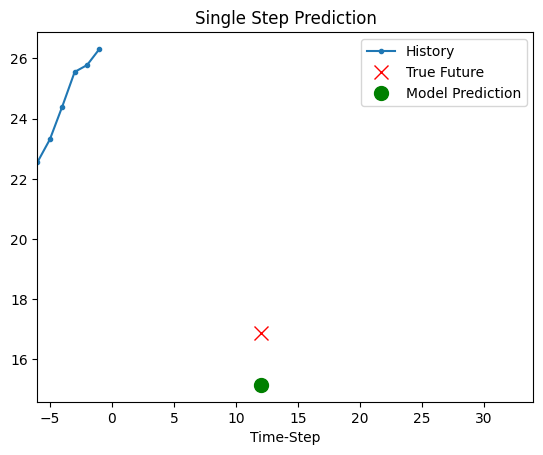

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


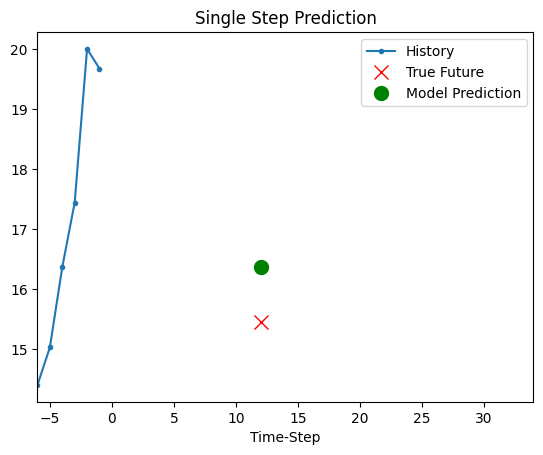

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


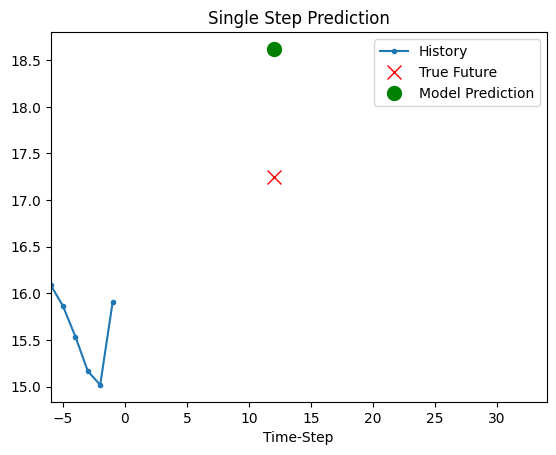

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


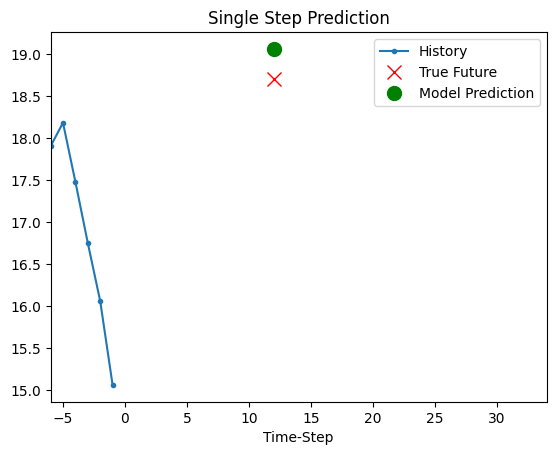

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


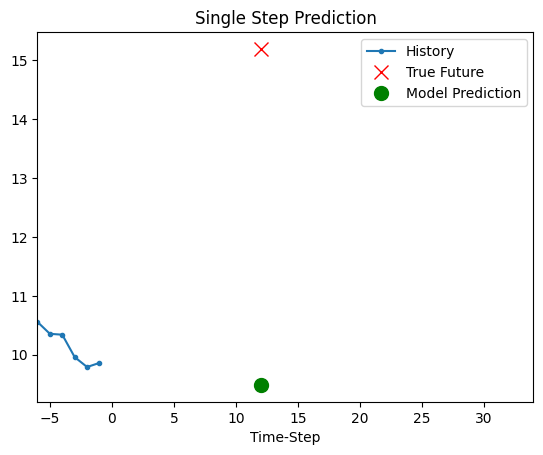

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


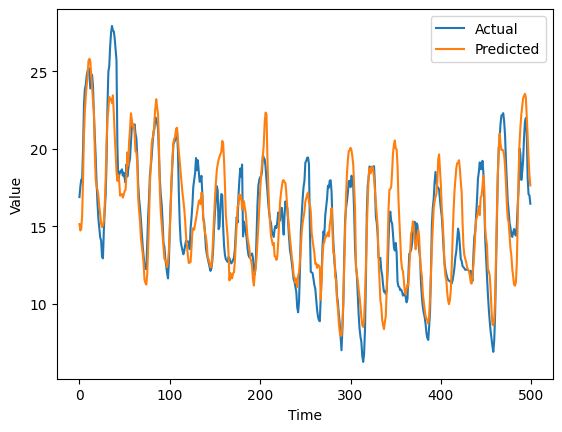

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


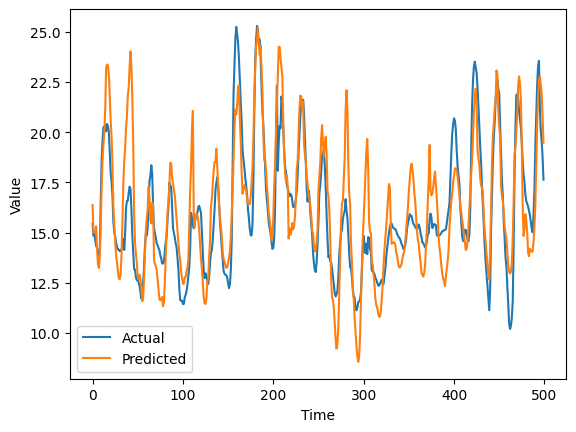

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


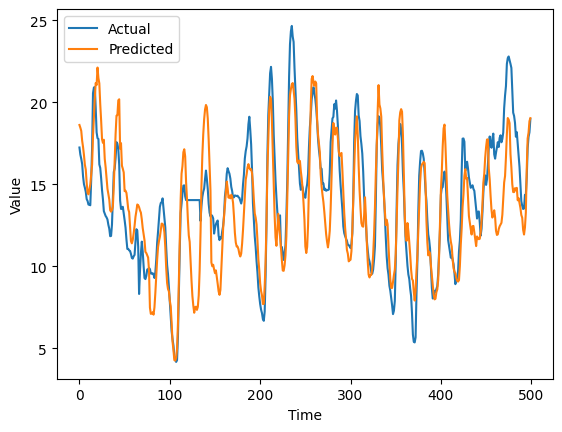

In [81]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 5:  Obtain a good model for predicting the temperature in 24h

Try different architectures and different values for `window_size`

In [ ]:
horizon = 24

In [82]:
## previous hours to consider
window_size = 48

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 48, 15)
Target shape: (128,)


In [83]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [85]:
inputs = layers.Input(shape=(window_size, num_features))
inputs_norm = norm(inputs)


l_1 = keras.layers.GRU(128, return_sequences=False)(inputs_norm)
l_1 = layers.Dropout(0.4)(l_1)
outputs = keras.layers.Dense(1)(l_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [87]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    381/Unknown 6s 7ms/step - loss: 43.4361
Epoch 1: val_loss improved from inf to 7.00681, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 43.1904 - val_loss: 7.0068
Epoch 2/25
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5649
Epoch 2: val_loss improved from 7.00681 to 6.15301, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5589 - val_loss: 6.1530
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7750
Epoch 3: val_loss improved from 6.15301 to 5.91843, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.7748 - val_loss: 5.9184
Epoch 4/25
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3140
Epoch 4: val_loss improved from 5.91843 to 5.60231, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.3146 - val_loss: 5.6023
Epoch 5/25
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


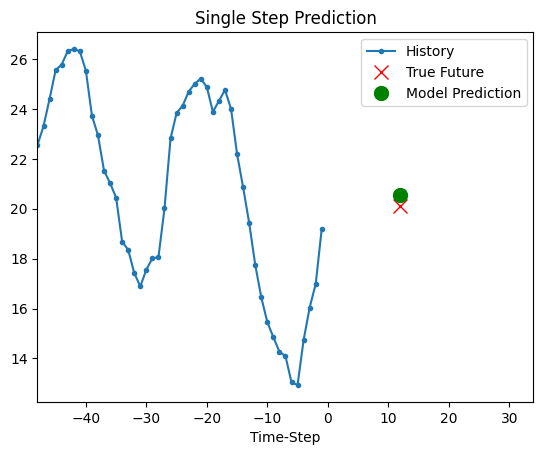

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


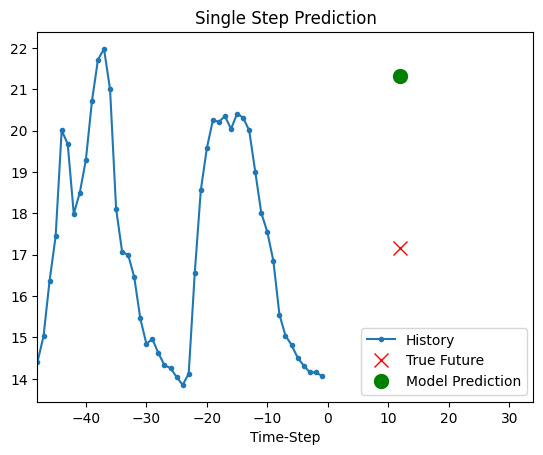

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


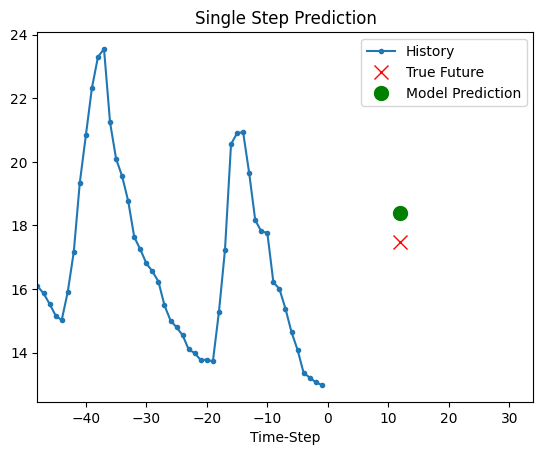

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


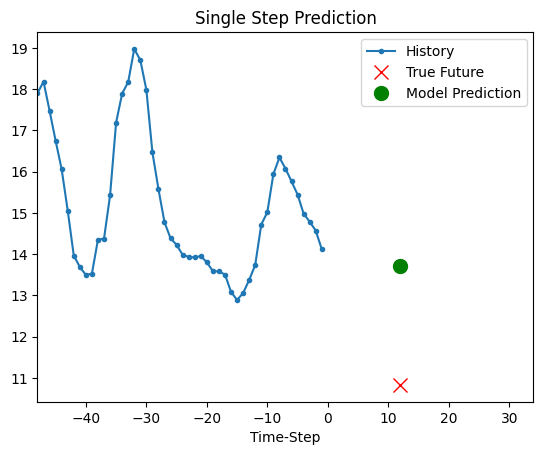

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


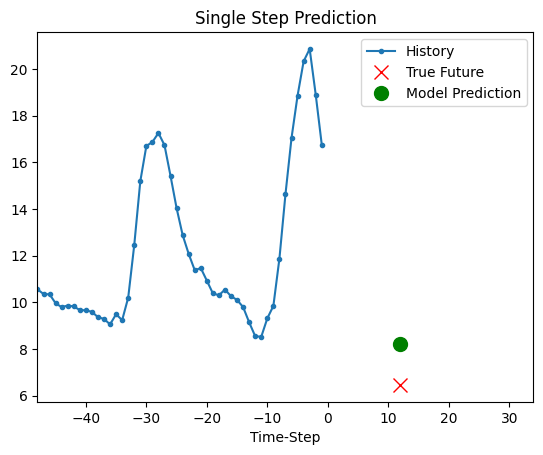

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


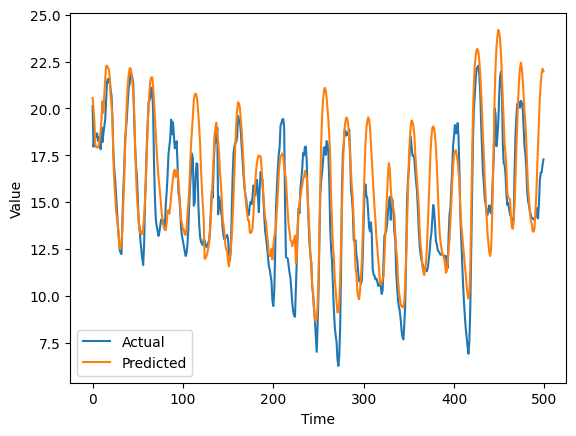

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


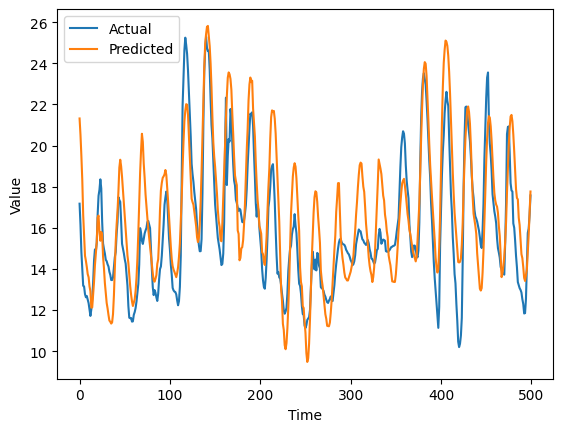

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


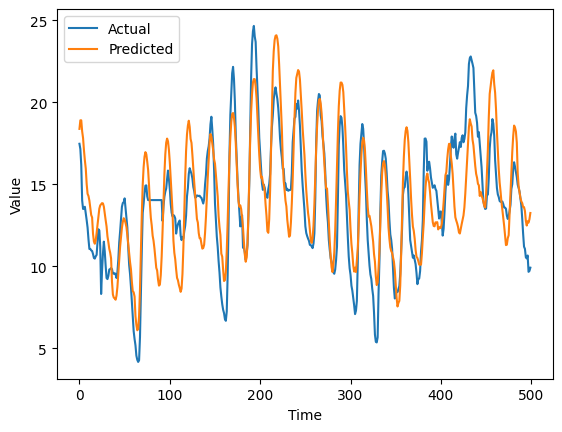

In [88]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## Practice: Cryptocurrency Forecasting

First of all, obtain and pre-process the data from [www.cryptodatadownload.com](www.cryptodatadownload.com)

In [89]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [90]:
# http://www.cryptodatadownload.com/cdd/gemini_{0}USD_1hr.csv
# '../data/gemini_{0}USD_1hr.csv'
def get_coin_df(fpath='../data/gemini_{0}USD_1hr.csv'):
    coins = ['BTC', 'ETH', 'LTC', 'ZEC', 'DOGE']
    file_path = fpath.format('BTC')
    print(file_path)
    df = pd.read_csv(file_path, parse_dates=['date'], skiprows=1, skipfooter=1)
    df = df[['date', 'open']]
    df = df.set_index('date')
    df = df.sort_index()
    df = df.rename(columns={'open': 'BTC'})
    for coin in ['ETH', 'LTC', 'ZEC', 'DOGE']:
        coin_path = fpath.format(coin)
        df_coin = pd.read_csv(coin_path,
                              parse_dates=['date'],
                              skiprows=1,
                              skipfooter=1)
        df_coin = df_coin[['date', 'open']]
        df_coin = df_coin.set_index('date')
        df_coin = df_coin.sort_index()
        df_coin = df_coin.rename(columns={'open': coin})
        df[coin] = np.nan
        df.loc[df_coin.index, coin] = df_coin.values.flatten()
    return df


df = get_coin_df(
    fpath='http://www.cryptodatadownload.com/cdd/Gemini_{0}USD_1h.csv')
df.tail()

http://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_1h.csv


/tmp/ipython-input-246478776.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, parse_dates=['date'], skiprows=1, skipfooter=1)
/tmp/ipython-input-246478776.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_coin = pd.read_csv(coin_path,
/tmp/ipython-input-246478776.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_coin = pd.read_csv(coin_path,
/tmp/ipython-input-246478776.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_coin = pd.read_csv(coin_path,
/tmp/ipython-input-246478776.p

,BTC,ETH,LTC,ZEC,DOGE
date,,,,,
2025-11-04 19:00:00,101313.58,3305.54,84.32,413.99,0.15955
2025-11-04 20:00:00,100473.17,3227.60,83.42,415.00,0.15780
2025-11-04 21:00:00,100679.51,3213.74,83.12,428.18,0.15885
2025-11-04 22:00:00,100240.94,3216.61,82.83,442.91,0.15840
2025-11-04 23:00:00,101287.97,3246.73,85.21,443.17,0.16341


In [91]:
df = df.diff()
df[df.columns] = np.sqrt(df.values)

/tmp/ipython-input-1445545816.py:2: RuntimeWarning: invalid value encountered in sqrt
  df[df.columns] = np.sqrt(df.values)


Lets visualize the scaled values

In [92]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = scaler.fit_transform(df)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

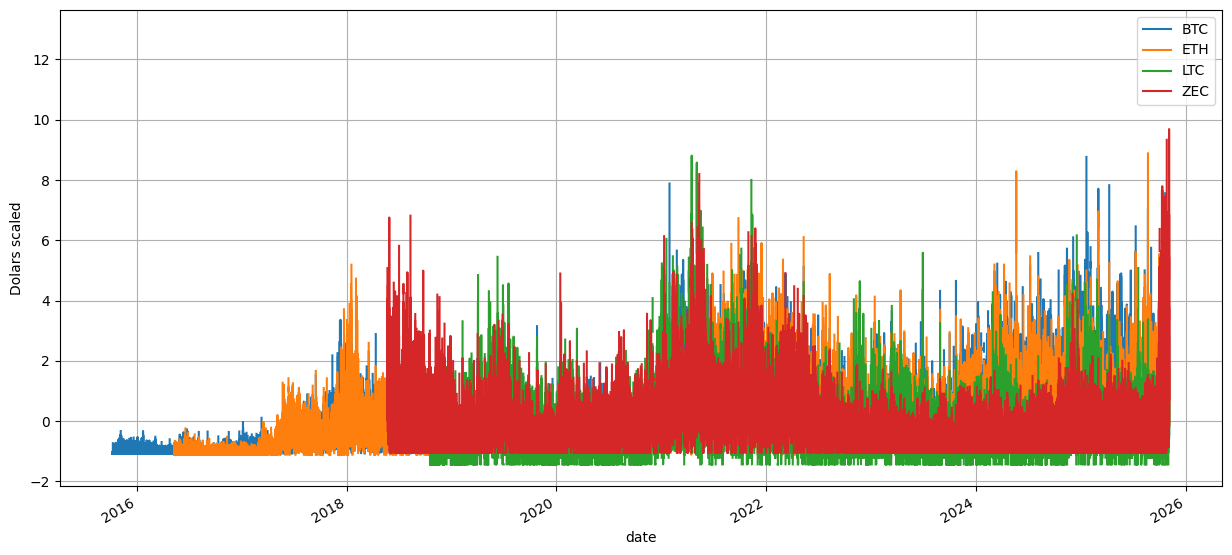

In [93]:
coins = ['BTC', 'ETH', 'LTC', 'ZEC']
for col in coins:
    df_normalized[col].plot(legend=True, figsize=(15, 7))
plt.ylabel('Dolars scaled')
plt.grid()
plt.show()

### Univariate Time Series
To start with, we will use only one cryptocurrency.

In [94]:
coin_target = 'ETH' #  Coin that we want to predict, ['BTC', 'ETH', 'LTC', 'ZEC']
df_coin = df[coin_target].copy()
# delete nan rows
df_coin = df_coin.dropna()
df_coin.head()

,ETH
date,
2016-05-09 15:00:00,0.670820
2016-05-09 20:00:00,0.793725
2016-05-10 00:00:00,0.000000
2016-05-10 01:00:00,0.000000
2016-05-10 02:00:00,0.000000


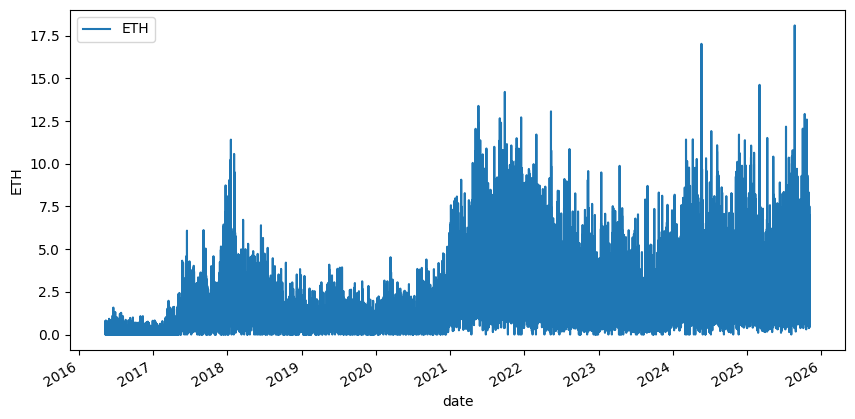

In [95]:
df_coin.plot(legend=True,figsize=(10,5))
plt.ylabel(coin_target)
plt.show()

In [96]:
# Train-test split
test_date = pd.Timestamp("2023-01-10")
init_date = pd.Timestamp("2017-10-08 14:00:00")

# train_data = df_coin.loc[df_coin.index < test_date].values

train_data = df_coin.loc[(df_coin.index < test_date) *
                         (df_coin.index > init_date)].values

test_data = df_coin.loc[df_coin.index >= test_date].values

#### Data normalization

In [97]:
mu = train_data.mean()
sigma = train_data.std()
print('mu, sigma: ', mu, sigma)

train_data = (train_data - mu) / sigma
test_data = (test_data - mu) / sigma

mu, sigma:  2.0838377162850157 1.7868657561940413


这段是在做标准化（z-score）：用训练集的均值和标准差去变换 train/test，避免数据泄漏。

**放在哪里：**时间切分之后、建窗口/喂模型之前；或用 tf.keras.layers.Normalization(...).adapt(train_X) 达到同样效果。

### Question 1: Create a model to predict the ETH value in 24h, `RMSE(test) < 50$`

In [98]:
# Create windows
window_size, horizon = (6, 24)
X_train, y_train = create_windows_np(train_data, window_size, horizon, shuffle=True)
X_test, y_test = create_windows_np(test_data, window_size, horizon, shuffle=False)

In [99]:
X_test[0, :], y_test[0], test_data[:window_size + horizon]

(array([ 0.3323405 , -0.11920818, -0.17767733,  0.13308198, -0.77444974,
        -0.0357815 ]),
 np.float64(-0.3947878225494156),
 array([ 0.3323405 , -0.11920818, -0.17767733,  0.13308198, -0.77444974,
        -0.0357815 , -0.18403444, -0.13275714, -0.5207898 ,  0.5560008 ,
        -0.1464861 , -0.94944983, -0.15264755, -0.88083604, -1.00790728,
        -0.66877899, -0.12370494, -0.55314318, -0.58191672, -0.56605102,
        -0.76263561, -0.32860597, -0.26554318,  0.52387598,  0.18854577,
        -0.46945203,  0.25400777,  2.29678904,  1.6145956 , -0.39478782]))

In [100]:
from tensorflow.keras import layers
## Modify the initial model to obtain better results

inputs = keras.layers.Input(shape=(window_size, 1))

l_1 = layers.SimpleRNN(1, return_sequences=False) (inputs)
outputs = layers.Dense(1)(l_1)

model = keras.Model(inputs=inputs, outputs=outputs)




model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2, shuffle=True, batch_size = 64, callbacks=[es_callback]
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 6, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6527 - val_loss: 0.5661
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5793 - val_loss: 0.5547
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5459 - val_loss: 0.5499
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5263 - val_loss: 0.5474
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5597 - val_loss: 0.5457
Epoch 6/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5462 - val_loss: 0.5450
Epoch 7/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5471 - val_loss: 0.5441
Epoch 8/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5454 - val_loss: 0.5433
Epoch 9/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5295 - val_loss: 0.5437
Epoch 10/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5526 - val_loss: 0.5426
Epoch 11/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5445 - val_loss: 0.5423
Epoch 12/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [101]:
results = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results))

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6875
Test Loss: 0.8782677054405212


393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
max deviation:  14.373718684967555
RMSE:  1.6745783126264304
MAE:  1.271960531138116


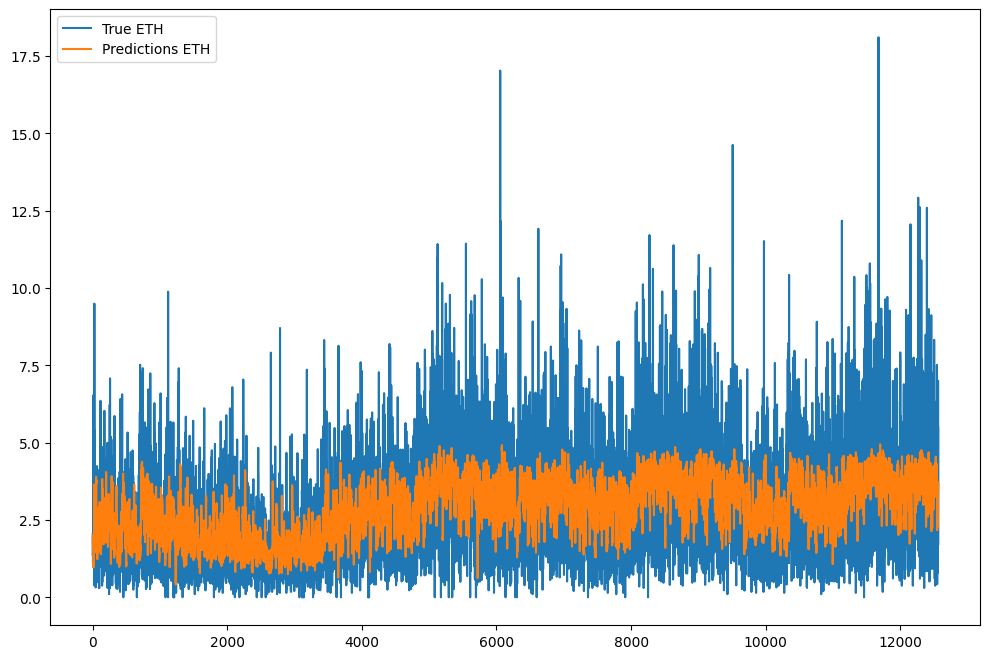

In [102]:
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target
print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)
plt.legend(['True {0}'.format(coin_target), 'Predictions {0}'.format(coin_target)])
plt.show()

## Multivariate Time Series

In [103]:
## You can try feature engineering with df
coin_target = 'ETH' # 'BTC'
coins =  ['ETH', 'LTC', 'ZEC', 'BTC'] # ['BTC', 'ETH', 'LTC', 'ZEC']
df_multi = df[coins].dropna()

In [104]:
# You can create new features

## moving average features
for coin in coins:
    df_multi[coin+'_week_mu'] = df_multi[coin].rolling(window=7*24).mean()
    df_multi[coin+'_week_sigma'] = df_multi[coin].rolling(window=7*24).std()
df_multi = df_multi.dropna()

## time features
dt = df_multi.index.to_numpy()
dt = (dt - dt.min()) / np.timedelta64(24 * 365, 'h')
df_multi['time'] = dt

数据是“按小时”的，所以 7*24=一周 168 小时窗口。

为每个币新增两列：一周移动均值（week_mu）和一周移动标准差（week_sigma）。

dropna() 把前面不够 168 小时的起始几行丢掉（也可以用 min_periods=7*24 更显式）。

把时间索引转成从最早时刻起的“年数”（小时为单位再除以一年小时数）。

这给模型一个单调的时间位置特征；你也可以加日/周/年周期的 sin/cos 特征。

In [105]:
train_data = df_multi.loc[(df_multi.index < test_date) * (df_multi.index > init_date ), : ].copy()
test_data = df_multi.loc[df_multi.index >= test_date, :].copy()

#### Normalize Data

In [106]:
features = df_multi.columns
mu_dict = {}
sigma_dict = {}
for c in features:
    mu = train_data[c].mean()
    sigma = train_data[c].std()
    mu_dict[c] = mu
    sigma_dict[c] = sigma
    print('feature: {0} , mu,sigma'.format(c), mu, sigma)
print(mu_dict, sigma_dict)

feature: ETH , mu,sigma 2.660751731604951 2.0881494238708345
feature: LTC , mu,sigma 0.8299432021588845 0.5365672224500567
feature: ZEC , mu,sigma 0.8233092691685281 0.5549576256808358
feature: BTC , mu,sigma 10.332859811334096 7.196810733060666
feature: ETH_week_mu , mu,sigma 2.654960901531253 1.6269608903847756
feature: ETH_week_sigma , mu,sigma 1.1587924343611327 0.6257574719765375
feature: LTC_week_mu , mu,sigma 0.8291181752096638 0.34604307161340303
feature: LTC_week_sigma , mu,sigma 0.38727780233686776 0.1406839058460168
feature: ZEC_week_mu , mu,sigma 0.8271312526410933 0.34184898559722743
feature: ZEC_week_sigma , mu,sigma 0.4138890432400062 0.14935576454909674
feature: BTC_week_mu , mu,sigma 10.327387843464045 5.065121775992529
feature: BTC_week_sigma , mu,sigma 4.744796923021079 1.968310172078276
feature: time , mu,sigma 2.1184432948986487 1.1660324569435077
{'ETH': np.float64(2.660751731604951), 'LTC': np.float64(0.8299432021588845), 'ZEC': np.float64(0.8233092691685281), 'B

In [107]:
for c in features:
    mu = mu_dict[c]
    sigma = sigma_dict[c]
    train_data.loc[:, c] = (train_data[c].values - mu) / sigma
    test_data.loc[:, c] = (test_data[c].values - mu) / sigma
train_data.describe()

,ETH,LTC,ZEC,BTC,ETH_week_mu,ETH_week_sigma,LTC_week_mu,LTC_week_sigma,ZEC_week_mu,ZEC_week_sigma,BTC_week_mu,BTC_week_sigma,time
count,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04,1.023500e+04
mean,1.443995e-16,9.996889e-17,1.221842e-16,-1.277380e-16,-1.555072e-16,-4.443062e-17,-1.332918e-16,2.221531e-16,9.996889e-17,-4.109832e-16,1.055227e-16,6.664592e-17,1.332918e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.274215e+00,-1.546765e+00,-1.483553e+00,-1.435755e+00,-1.237148e+00,-1.279885e+00,-1.324658e+00,-1.412591e+00,-1.374827e+00,-1.474878e+00,-1.537179e+00,-1.762310e+00,-1.816796e+00
25%,-7.788445e-01,-6.726121e-01,-6.777016e-01,-7.404476e-01,-9.654539e-01,-9.721341e-01,-7.447353e-01,-7.347143e-01,-8.253401e-01,-7.621932e-01,-8.730560e-01,-8.933042e-01,-8.312800e-01
50%,-3.212303e-01,-2.158171e-01,-1.967113e-01,-2.660931e-01,-3.437423e-01,-6.408553e-02,-3.238993e-01,-2.945343e-01,-2.079021e-01,-1.684969e-01,-2.846729e-01,-2.104452e-01,3.587437e-02
75%,5.802200e-01,4.518303e-01,4.779921e-01,5.300127e-01,9.019793e-01,8.195608e-01,4.872833e-01,5.744728e-01,6.432333e-01,5.005515e-01,8.884164e-01,9.285388e-01,8.593161e-01
max,5.530616e+00,1.065157e+01,8.171547e+00,7.416478e+00,2.699756e+00,2.214644e+00,3.734192e+00,3.327200e+00,3.760886e+00,3.326545e+00,2.224722e+00,2.534744e+00,1.732393e+00


### Question 2: Create a model to predict the ETH value in 24h, `RMSE(test) < 50$`

In [108]:
# Create windows
window_size, horizon = (48, 24)
X_train, y_train = create_windows_np(train_data, window_size, horizon, shuffle=True)
X_test, y_test = create_windows_np(test_data, window_size, horizon, shuffle=False)

KeyError: 71

In [ ]:
## Create windows
window_size, horizon = (..., 24)

columns = df_multi.columns
# Get the target column index
target_col_idx = columns.get_loc(coin_target)

X_train, y_train = create_windows_multivariate_np(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)
X_test, y_test = create_windows_multivariate_np(
    test_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

In [ ]:
X_train.shape, y_train.shape, X_test.shape

In [ ]:
from tensorflow.keras import layers

inputs = keras.layers.Input(shape=(window_size, len(features)))
...

outputs = layers.Dense(1)(...)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

model.summary()
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2, shuffle=True, batch_size = 64, callbacks=[es_callback]
)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results))

In [ ]:
sigma = sigma_dict[coin_target]
mu = mu_dict[coin_target]
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target
print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)
plt.legend(['True {0}'.format(coin_target), 'Predictions {0}'.format(coin_target)])
plt.show()

## Practice: Finance time series, SP500

In [1]:
# Download yahoo finance library
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download the list of S&P 500 companies
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data = pd.read_html(sp500_url)
sp500_table = data[0]
sp500_tickers = sp500_table['Symbol'].tolist()

# Download hourly stock data for each company
start_date = '2022-01-01'
end_date = '2023-05-06'
interval = '1h'

data_dict = {}
for ticker in tqdm(sp500_tickers):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
        data_dict[ticker] = stock_data['Close']
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

# Create a DataFrame with every company in the columns
data_df = pd.DataFrame(data_dict)

In [ ]:
cols = ['MSFT', 'META', 'GOOGL', 'AMZN']
data_df[cols].plot(figsize=(15, 7), legend=False)
plt.title("S&P 500 Hourly Stock Data")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()


## References

https://www.tensorflow.org/guide/keras/rnn

https://keras.io/examples/timeseries/timeseries_weather_forecasting/